# Feature Engineering

## Objectives

- Evaluate missing data in the datasets to confirm the effectiveness of prior cleaning.
- Apply feature engineering techniques (e.g., numerical transformations, ordinal encoding, outlier handling) to improve feature distributions and predictive power.
- Analyze numerical features using transformations like Yeo-Johnson and Log10 to address skewness and stabilize variance.
- Document the transformation strategy for each feature in a summary table.

## Inputs
- Datasets:
  - `outputs/datasets/collection/TrainSet_cleaned.csv`
  - `outputs/datasets/collection/TestSet_cleaned.csv`

## Outputs
- Transformed datasets saved as CSV files (paths not specified in the provided notebook but assumed to follow the pattern):
  - `outputs/datasets/collection/TrainSet_engineered.csv`
  - `outputs/datasets/collection/TestSet_engineered.csv`


# Change working directory

We need to change the working directory from its current folder to its parent folder



In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/notebooks'

We want to make the parent of the current directory the new current directory



In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory



In [3]:
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices'

## Load data

In [4]:
import pandas as pd

TrainSet = pd.read_csv("outputs/datasets/collection/TrainSet_cleaned.csv")
TestSet = pd.read_csv("outputs/datasets/collection/TestSet_cleaned.csv")

TrainSet.info()
TestSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null 

In [5]:
print(TrainSet['BsmtExposure'].dtypes)


object


In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [7]:
EvaluateMissingData(TrainSet)

Empty DataFrame
Columns: [RowsWithMissingData, PercentageOfDataset, DataType]
Index: []

In [8]:
TestSet.head(5)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1068       0.0           3.0           No         663          GLQ   
1      1500       NaN           3.0           Av        1032          GLQ   
2      1028       NaN           2.0           No           0          Unf   
3      1004       NaN           3.0           No         399          ALQ   
4      1620       0.0           2.0           Gd        1022          GLQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        396         264          RFn       1963.0  ...     8414        70.0   
1        431         712          RFn       1994.0  ...    12256        98.0   
2       1008         360          Unf       1927.0  ...     8960        56.0   
3        605         420          NaN       1950.0  ...     5000        50.0   
4        598         912          Fin       2008.0  ...    12898        89.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            8            6         1059       1963   
1       362.0           32            5            8         1463       1994   
2         0.0            0            6            5         1008       1927   
3         0.0           24            7            6         1004       1947   
4        70.0            0            5            9         1620       2007   

   YearRemodAdd  SalePrice  
0          2003     154500  
1          1995     325000  
2          1950     115000  
3          1950     159000  
4          2008     315500  

[5 rows x 22 columns]

## custom function for feature engineering

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore') # ignore warnings for cleaner output

%matplotlib inline


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()
    print(f"skewness: {df[variable].skew().round(2)} | kurtosis: {df[variable].kurtosis().round(2)}")
    


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Categorcial encoding for categorical variables



In [10]:
variables_engineering = [
    'BsmtExposure',
    'BsmtFinType1',
    'GarageFinish',
    'KitchenQual'
]

variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

In [11]:
print(TrainSet[variables_engineering].dtypes)


BsmtExposure    object
BsmtFinType1    object
GarageFinish    object
KitchenQual     object
dtype: object


In [12]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           No          Rec          RFn          TA
1           No          Unf          RFn          TA
2           No          Unf      Missing          TA

In [13]:
EvaluateMissingData(df_engineering)

Empty DataFrame
Columns: [RowsWithMissingData, PercentageOfDataset, DataType]
Index: []

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



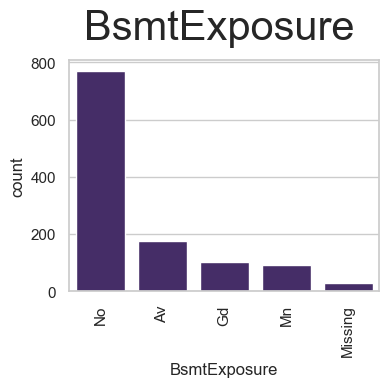

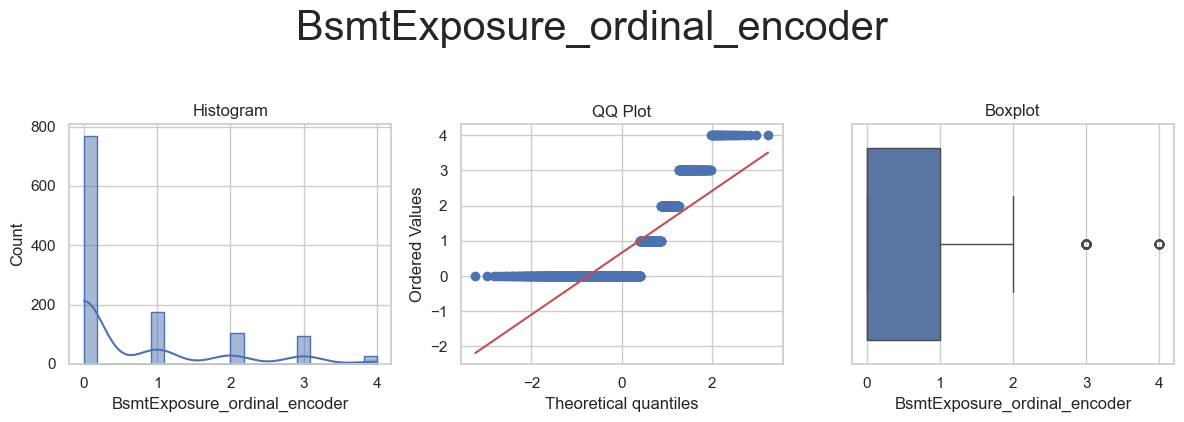

skewness: 1.54 | kurtosis: 1.26


* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



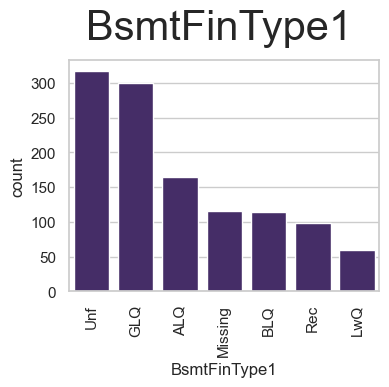

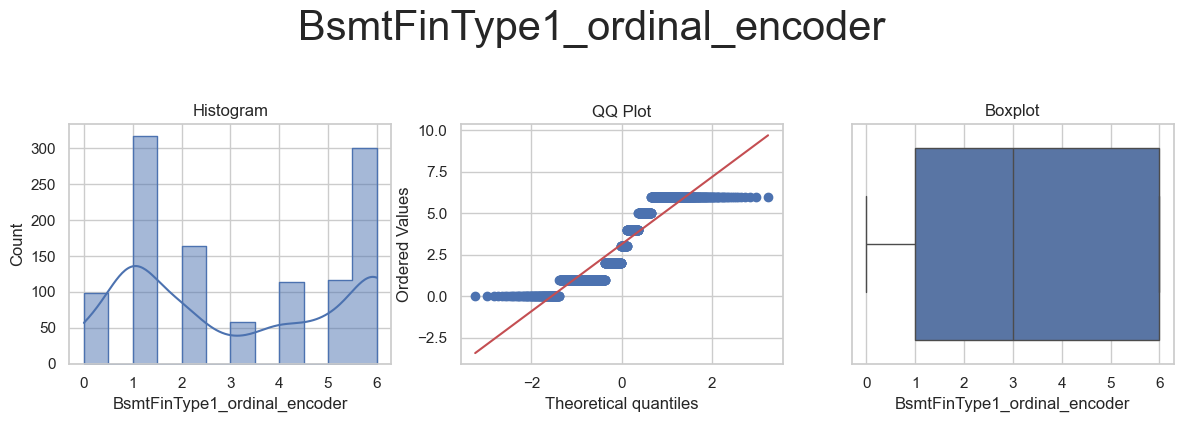

skewness: 0.13 | kurtosis: -1.57


* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



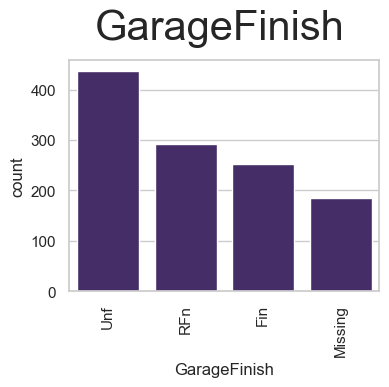

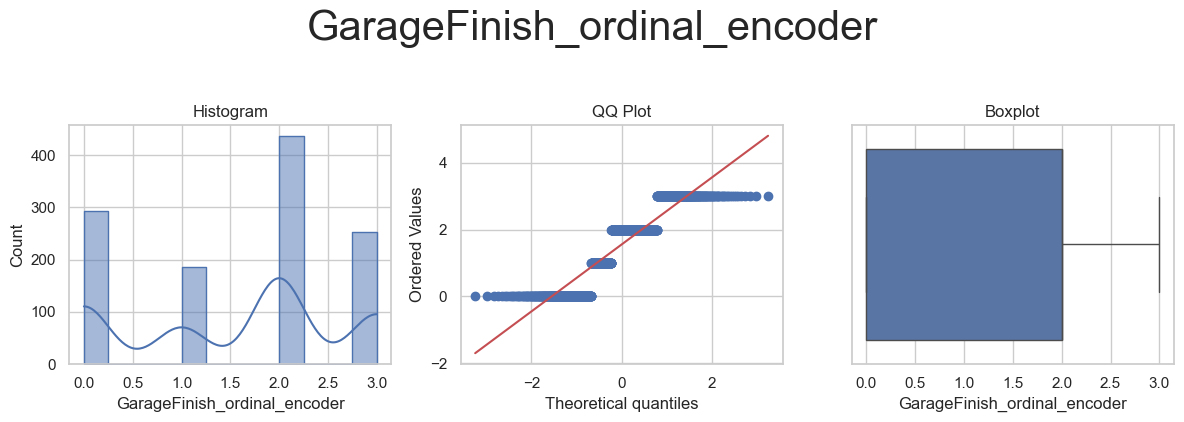

skewness: -0.22 | kurtosis: -1.25


* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



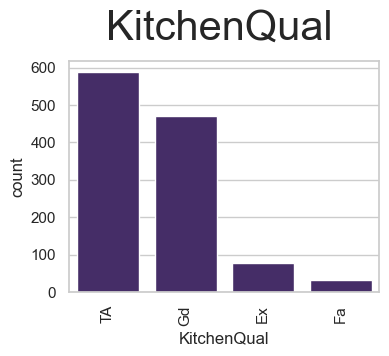

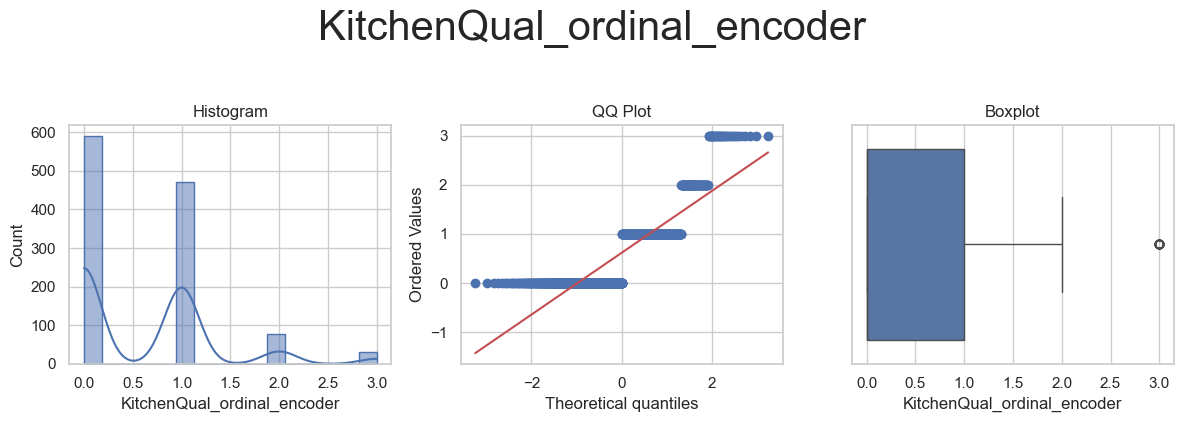

skewness: 1.16 | kurtosis: 1.27




In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')


In [15]:
df_engineering.head(3)

BsmtExposure  BsmtExposure_ordinal_encoder BsmtFinType1  \
0           No                             0          Rec   
1           No                             0          Unf   
2           No                             0          Unf   

   BsmtFinType1_ordinal_encoder GarageFinish  GarageFinish_ordinal_encoder  \
0                             0          RFn                             0   
1                             1          RFn                             0   
2                             1      Missing                             1   

  KitchenQual  KitchenQual_ordinal_encoder  
0          TA                            0  
1          TA                            0  
2          TA                            0

### the steps are: 
- create a transformer
- fit_transform into TrainSet
- transform into TestSet 

In [17]:


# Ensure the categorical features are of type 'object' or 'category'
TrainSet[variables_engineering] = TrainSet[variables_engineering].astype('object')
TestSet[variables_engineering] = TestSet[variables_engineering].astype('object')


encoder = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=variables_engineering,
    missing_values='ignore'  # allows NaN values to pass through
)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


In [25]:
# Ensure the categorical features are of type 'object' or 'category'
TrainSet[variables_engineering] = TrainSet[variables_engineering].astype('object')
TestSet[variables_engineering] = TestSet[variables_engineering].astype('object')

## numerical transformation

In [21]:
# Get list of numerical feature names
num_features = TrainSet.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preview the list
print("Numerical features:", num_features)

Numerical features: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


In [22]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

In [23]:
df_engineering = TrainSet[num_features].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtFinSF1  BsmtUnfSF  GarageArea  \
0      1314       0.0           3.0         922        392         294   
1       799     772.0           3.0           0        799         380   
2       796       0.0           2.0           0        796           0   

   GarageYrBlt  GrLivArea  LotArea  LotFrontage  MasVnrArea  OpenPorchSF  \
0       1957.0       1314     8400         70.0         0.0            0   
1       1993.0       1571     7837         59.0         0.0           40   
2          0.0        796     8777         67.0         0.0            0   

   OverallCond  OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0            6            5         1314       1957          1957     145000  
1            7            6          799       1993          1994     178000  
2            7            5          796       1910          1950      85000

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



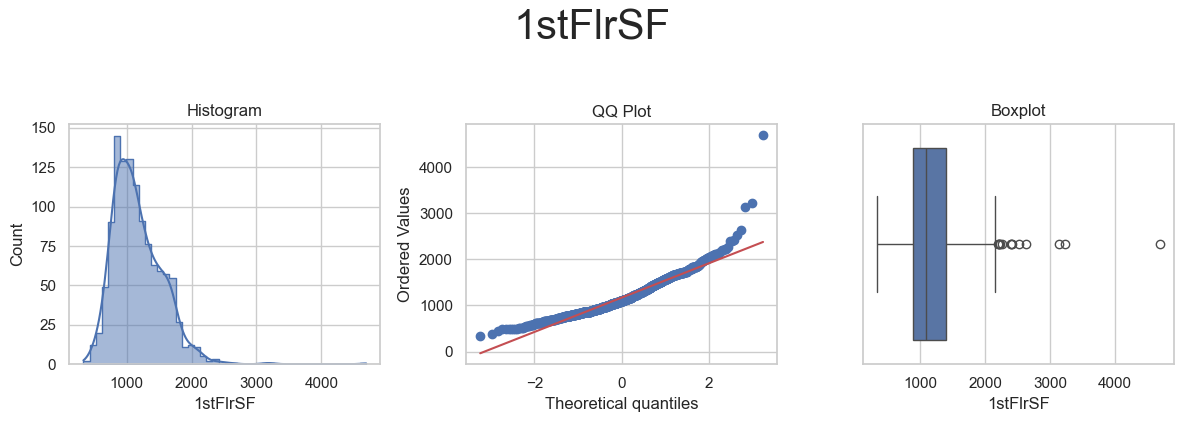

skewness: 1.42 | kurtosis: 6.7




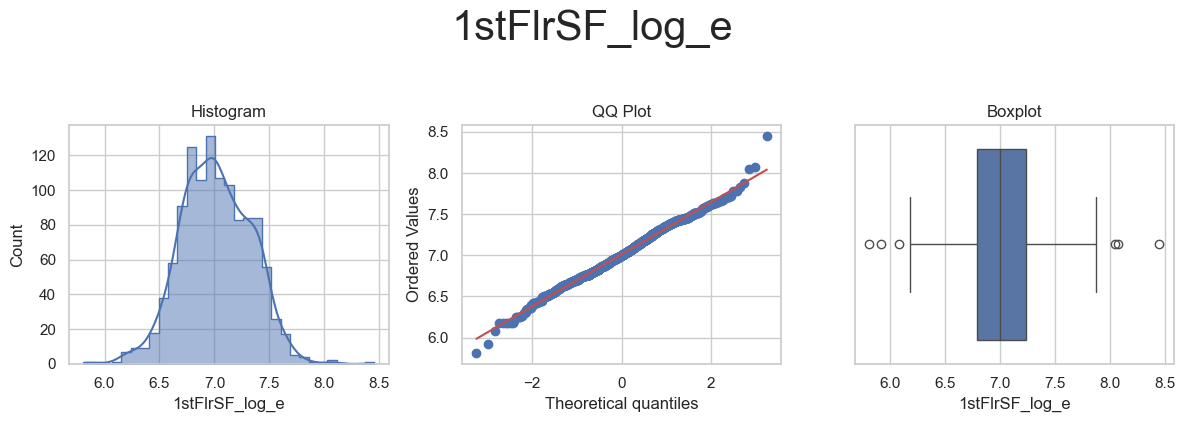

skewness: 0.03 | kurtosis: 0.23




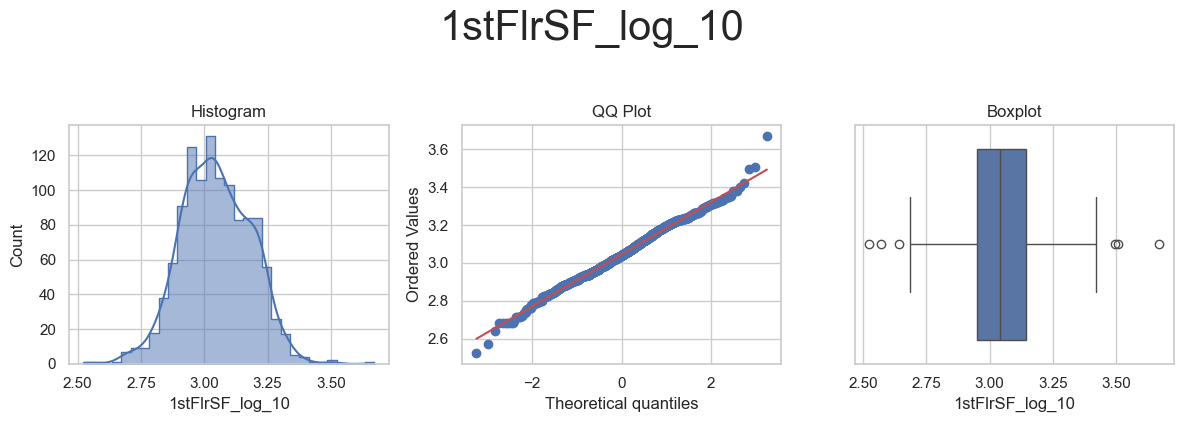

skewness: 0.03 | kurtosis: 0.23




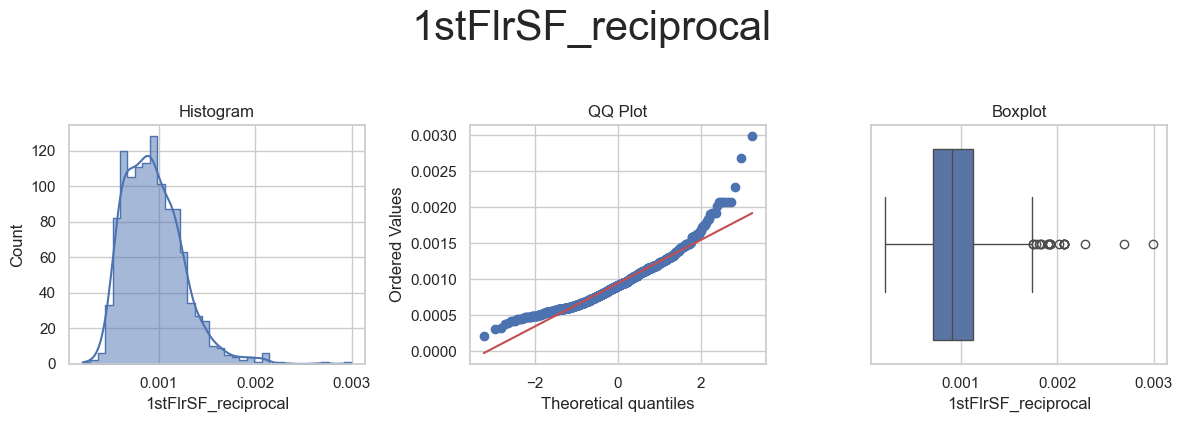

skewness: 1.14 | kurtosis: 3.14




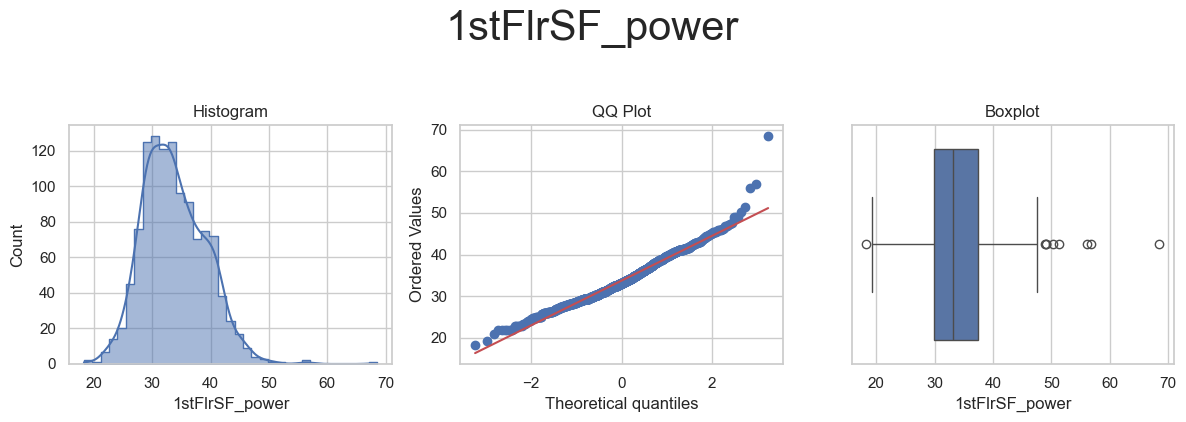

skewness: 0.6 | kurtosis: 1.4




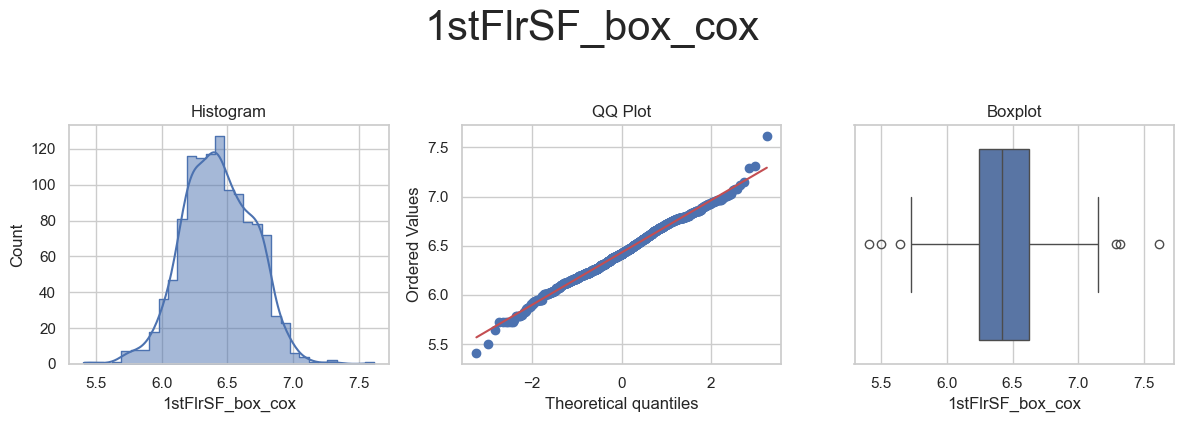

skewness: -0.0 | kurtosis: 0.23




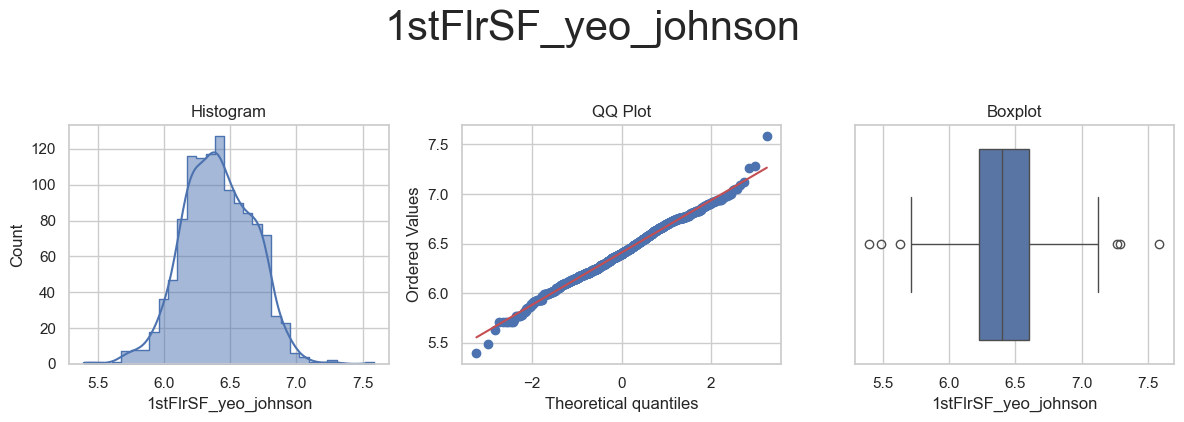

skewness: -0.0 | kurtosis: 0.23


* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



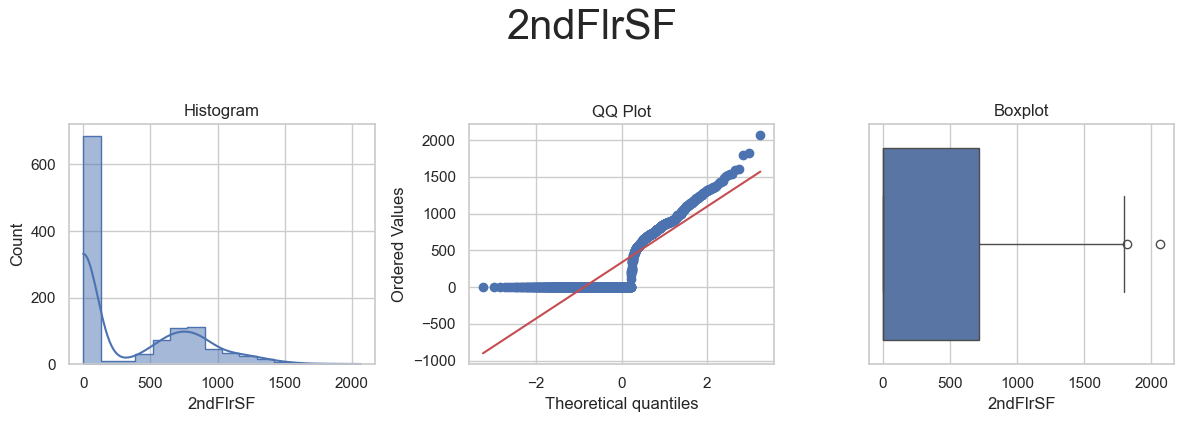

skewness: 0.88 | kurtosis: -0.45




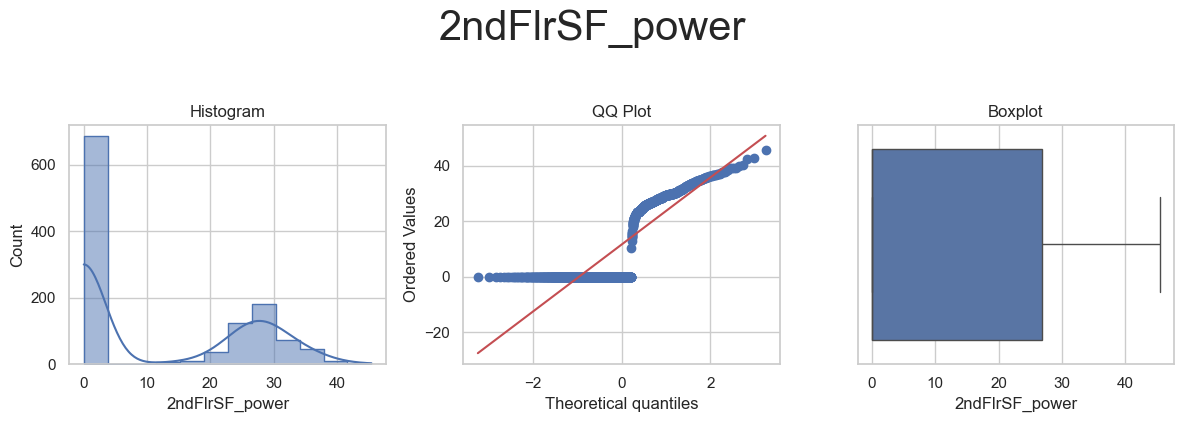

skewness: 0.5 | kurtosis: -1.57




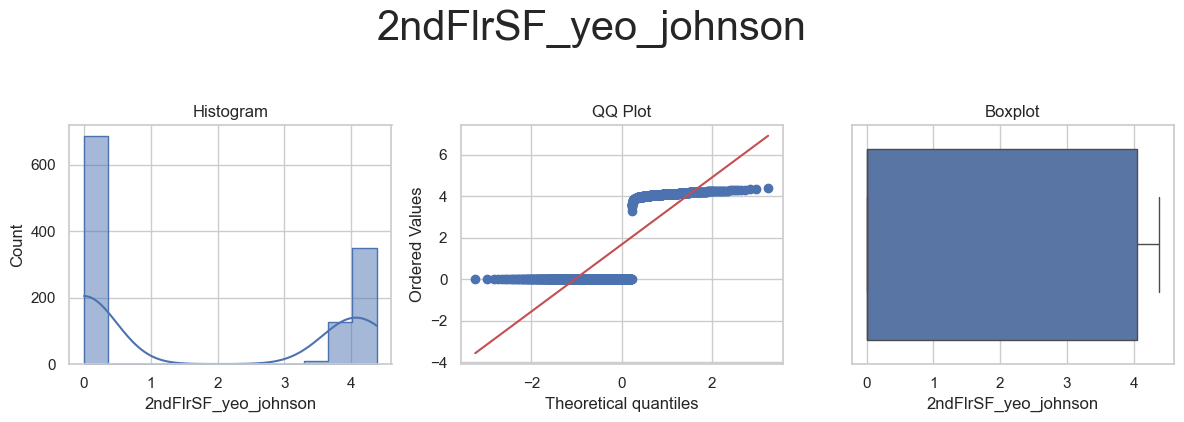

skewness: 0.36 | kurtosis: -1.87


* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



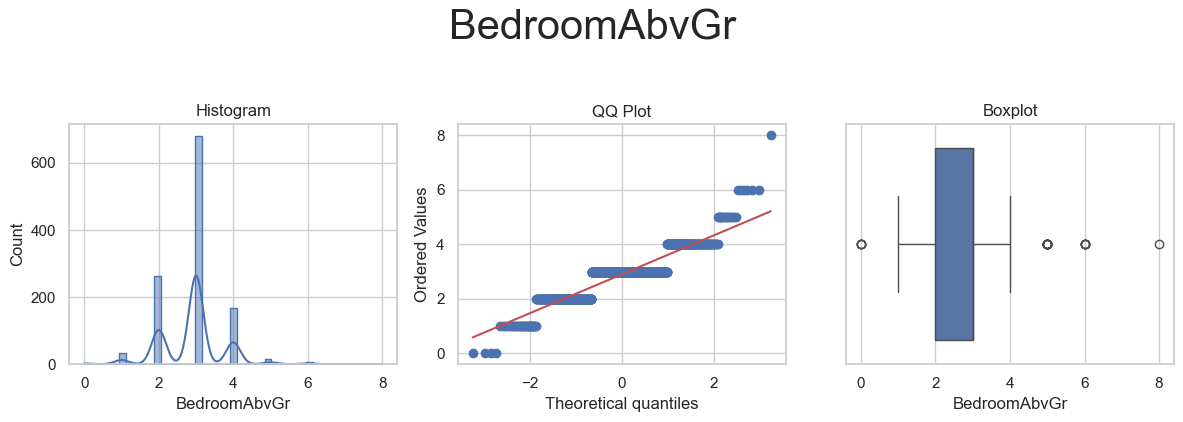

skewness: 0.29 | kurtosis: 2.98




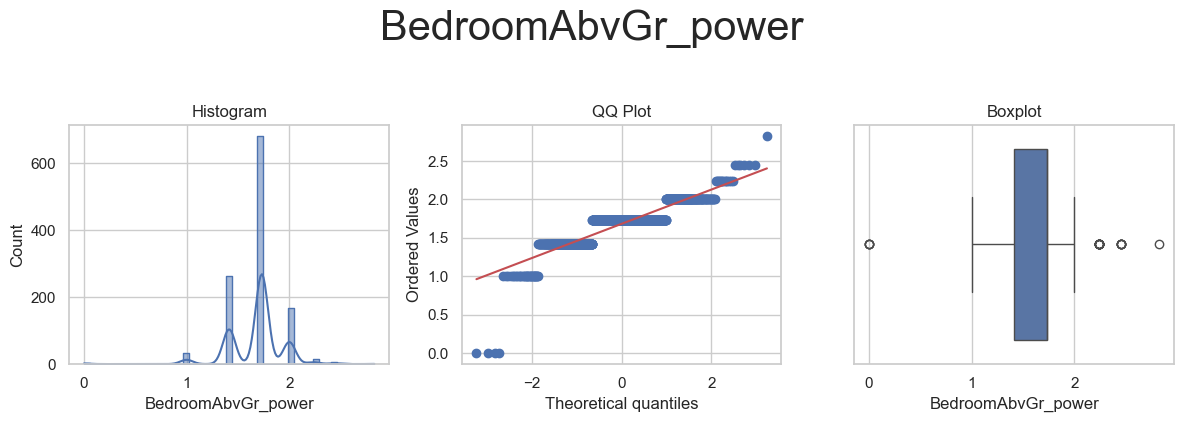

skewness: -1.24 | kurtosis: 7.45




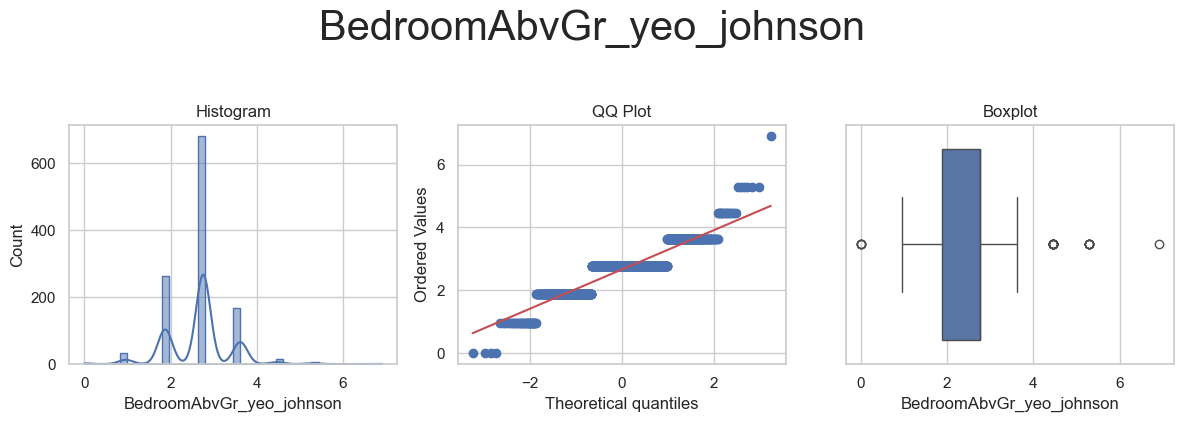

skewness: 0.15 | kurtosis: 2.74


* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



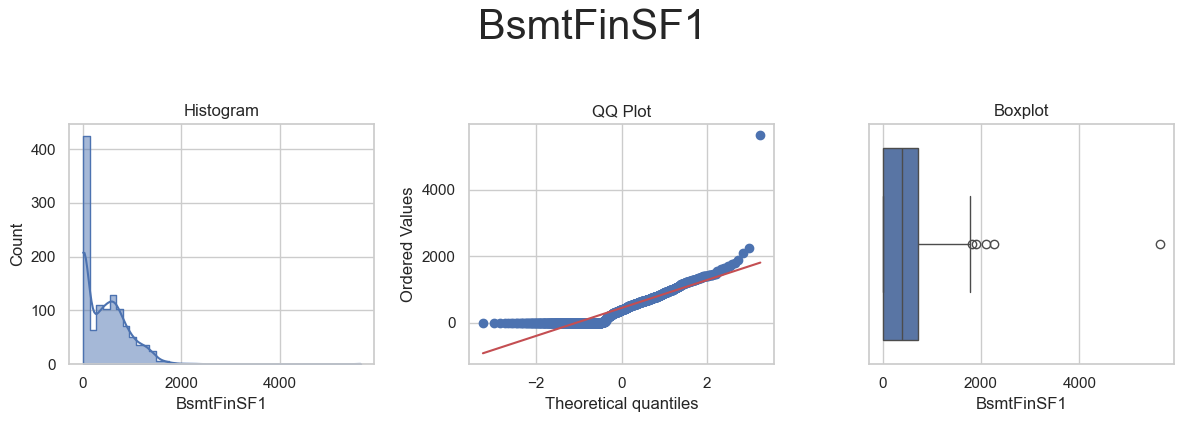

skewness: 1.86 | kurtosis: 13.48




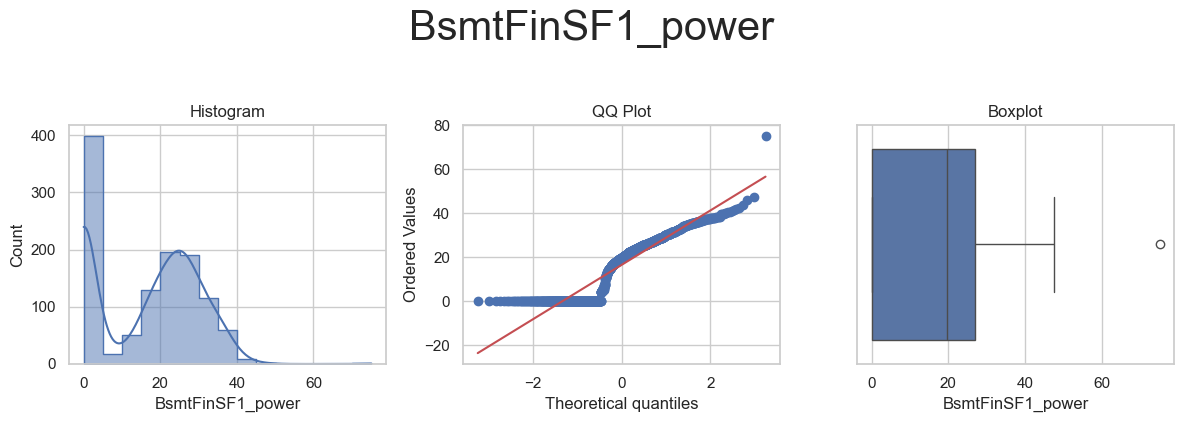

skewness: -0.03 | kurtosis: -1.11




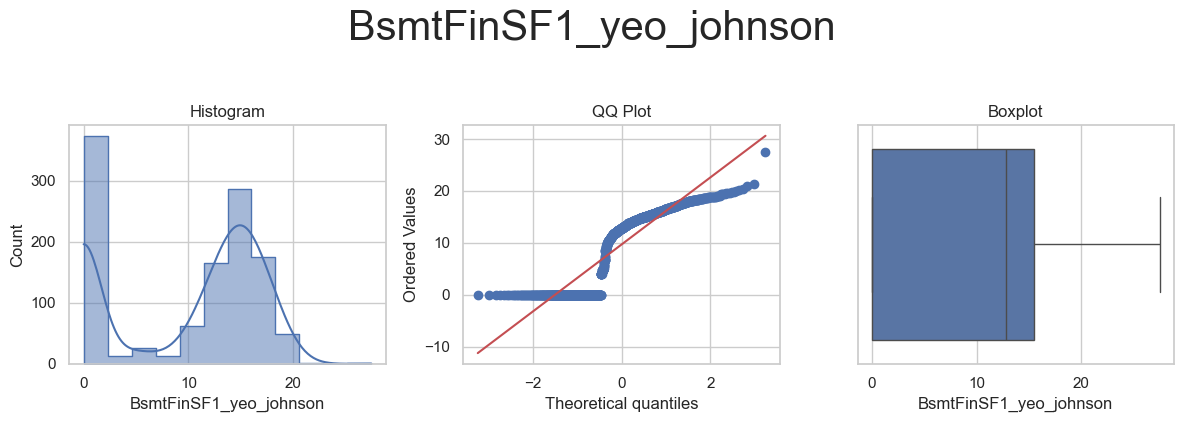

skewness: -0.42 | kurtosis: -1.5


* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



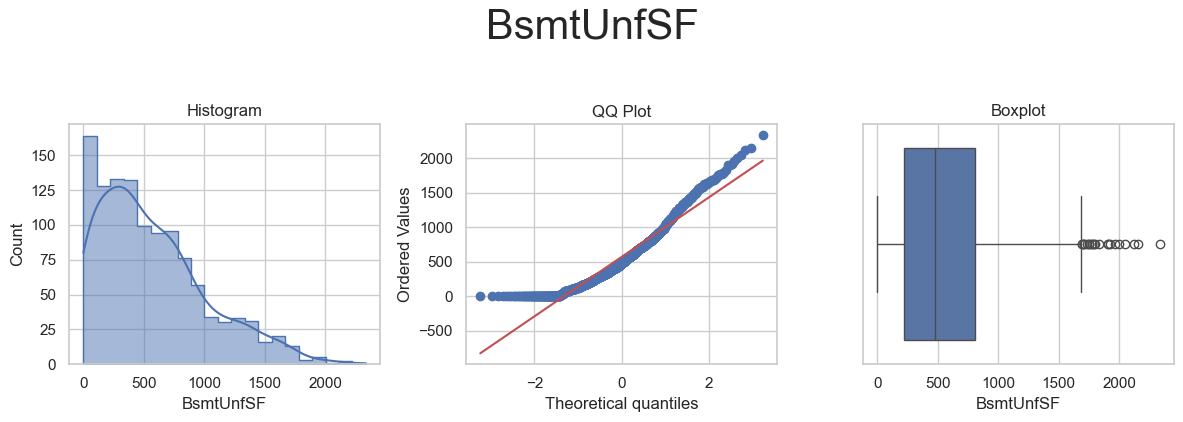

skewness: 0.91 | kurtosis: 0.4




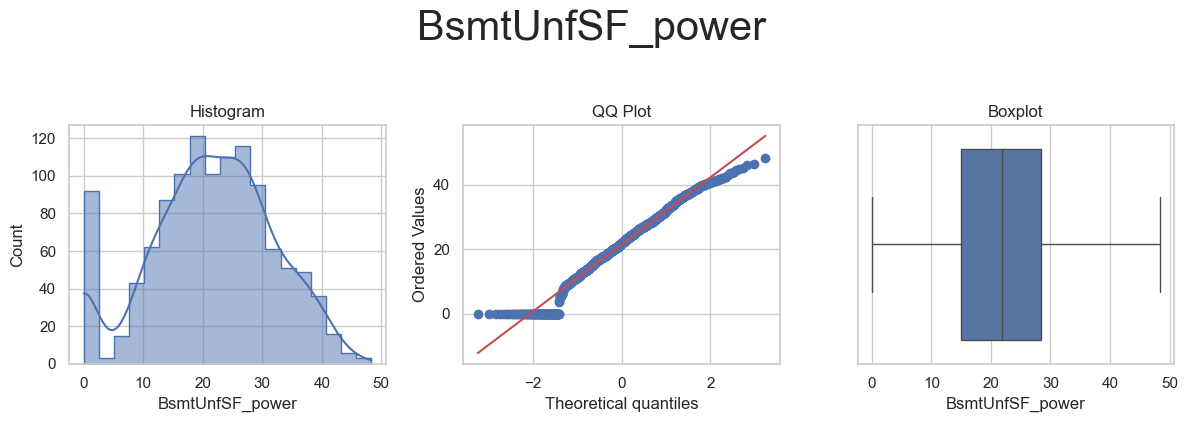

skewness: -0.23 | kurtosis: -0.31




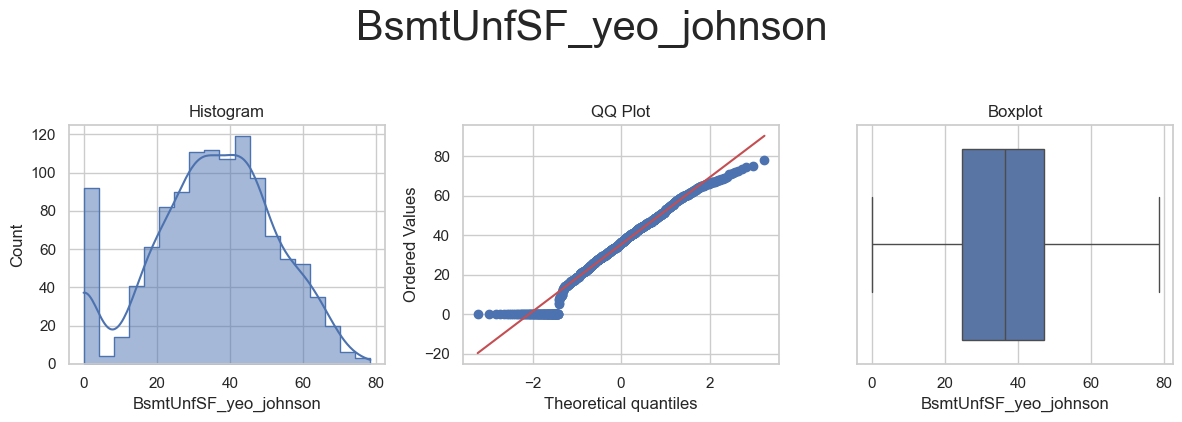

skewness: -0.27 | kurtosis: -0.31


* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



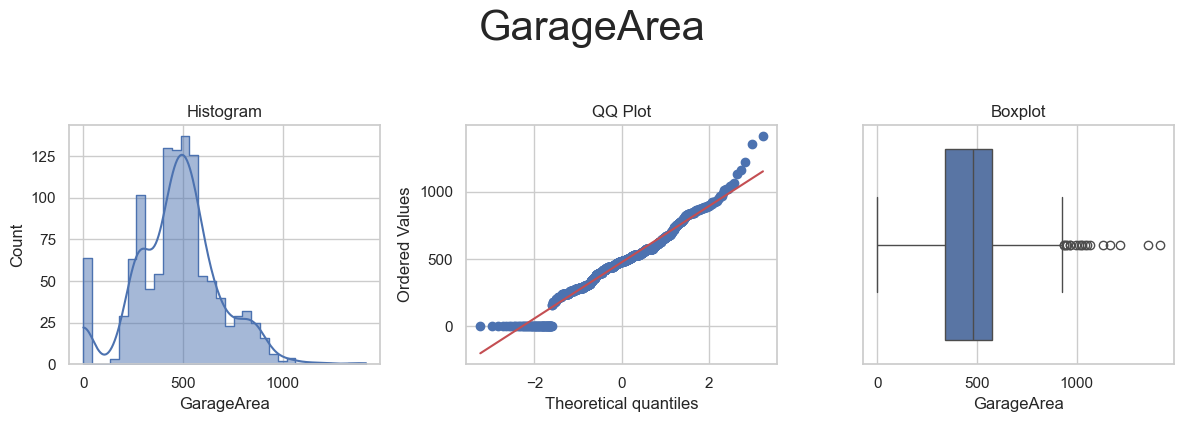

skewness: 0.11 | kurtosis: 0.88




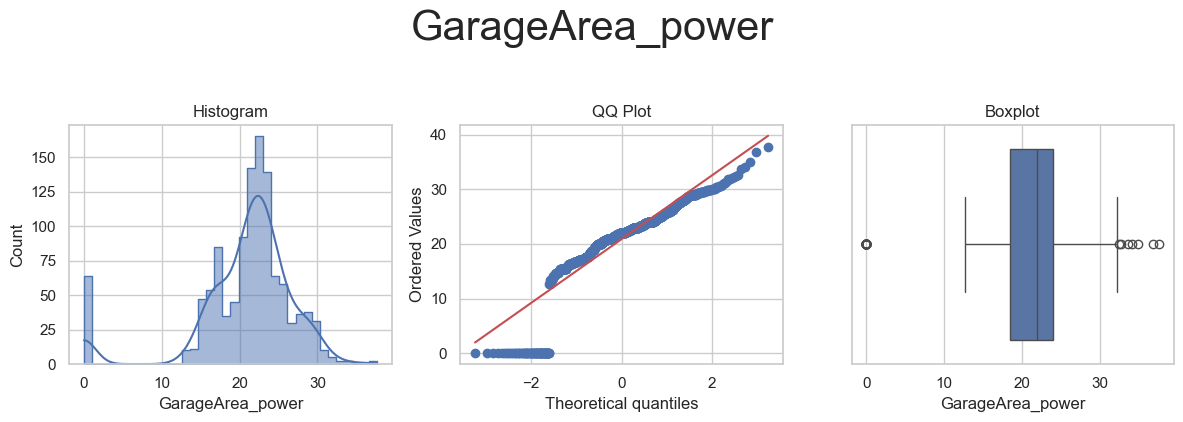

skewness: -1.66 | kurtosis: 3.93




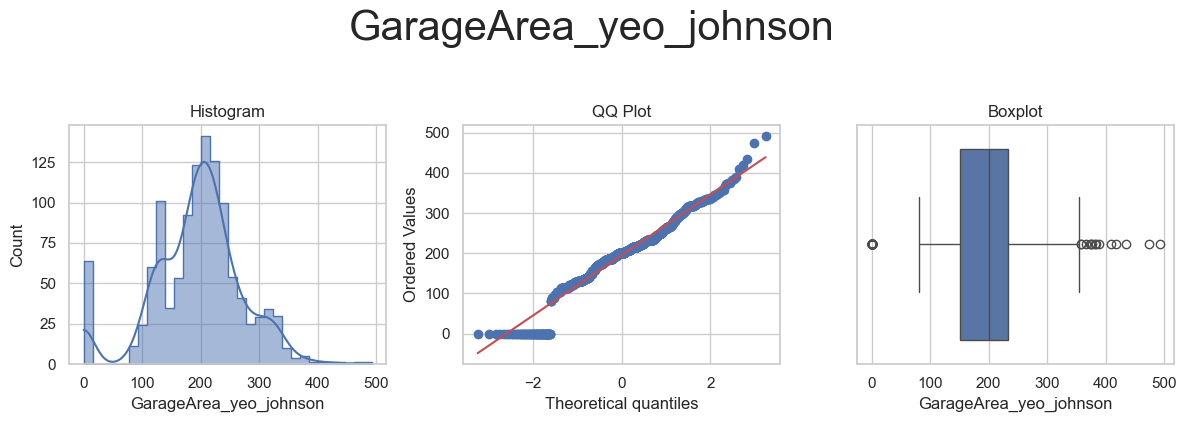

skewness: -0.35 | kurtosis: 1.05


* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_power', 'GarageYrBlt_yeo_johnson'] 



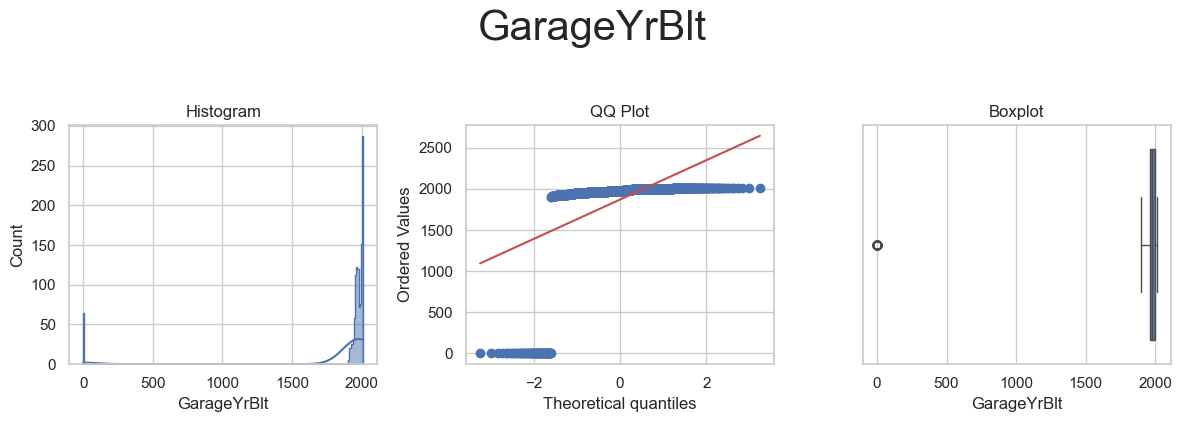

skewness: -3.9 | kurtosis: 13.28




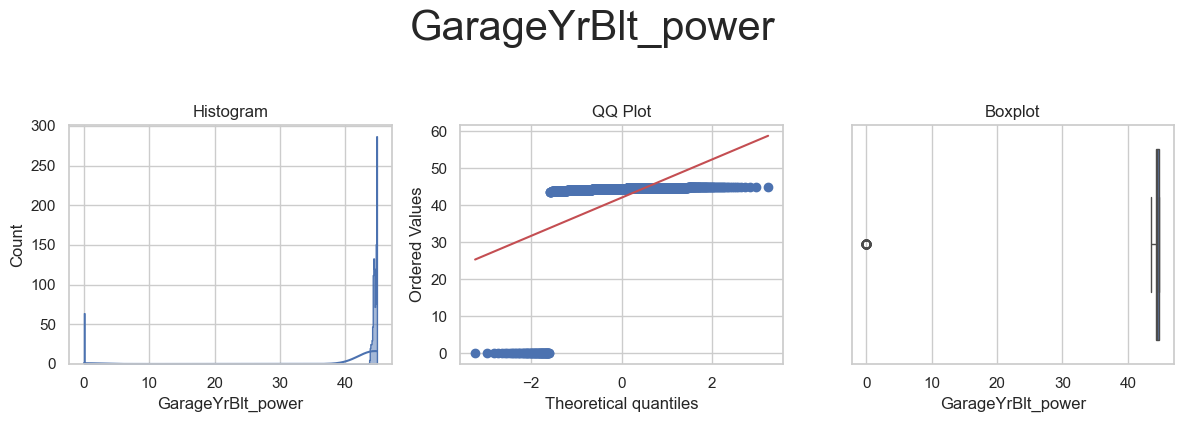

skewness: -3.91 | kurtosis: 13.35




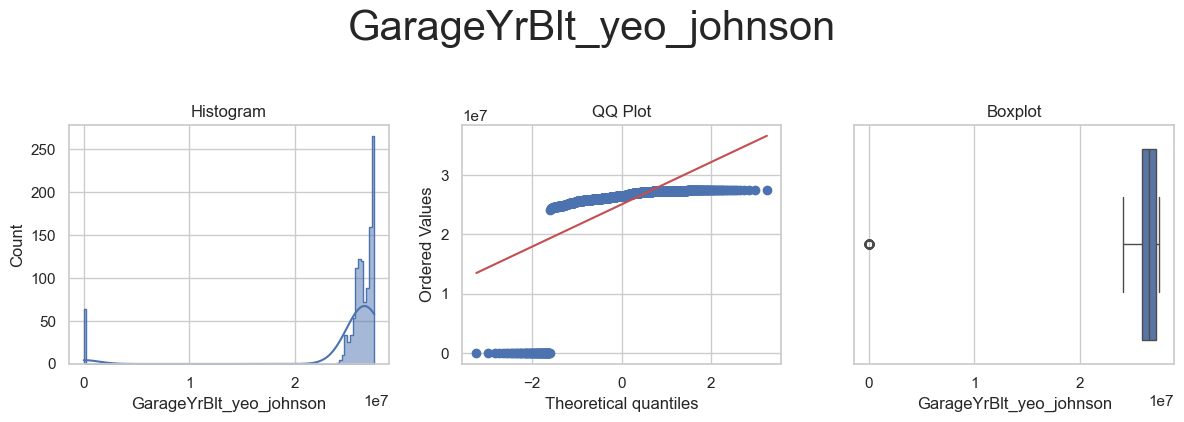

skewness: -3.82 | kurtosis: 12.87


* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



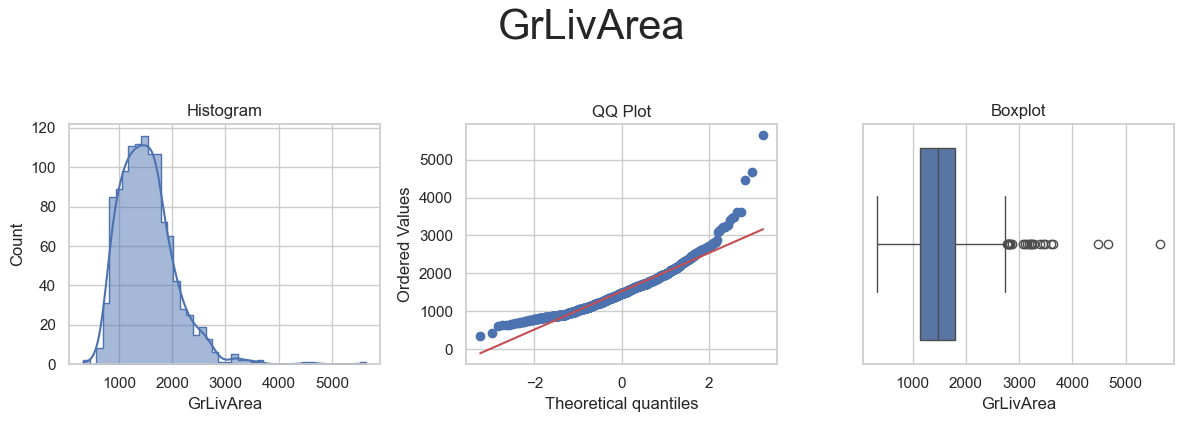

skewness: 1.43 | kurtosis: 5.45




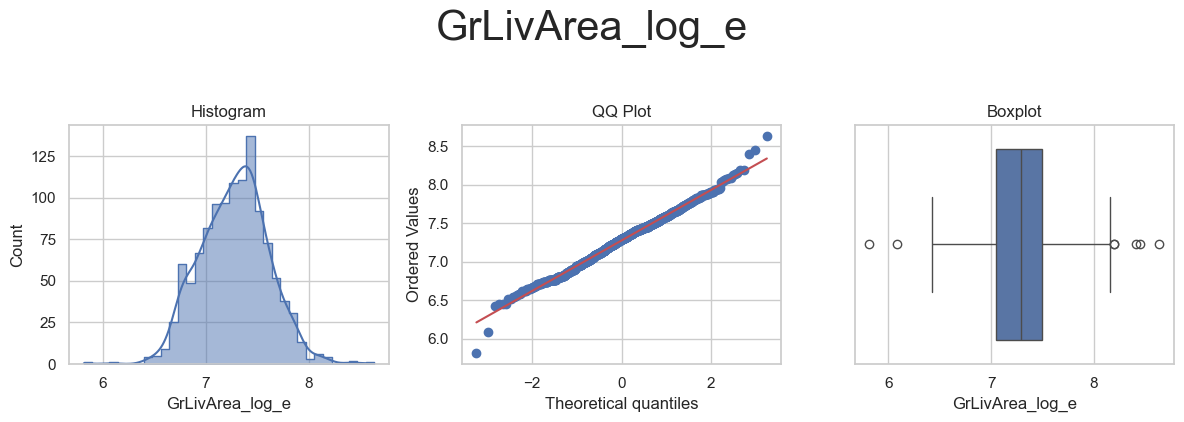

skewness: 0.01 | kurtosis: 0.35




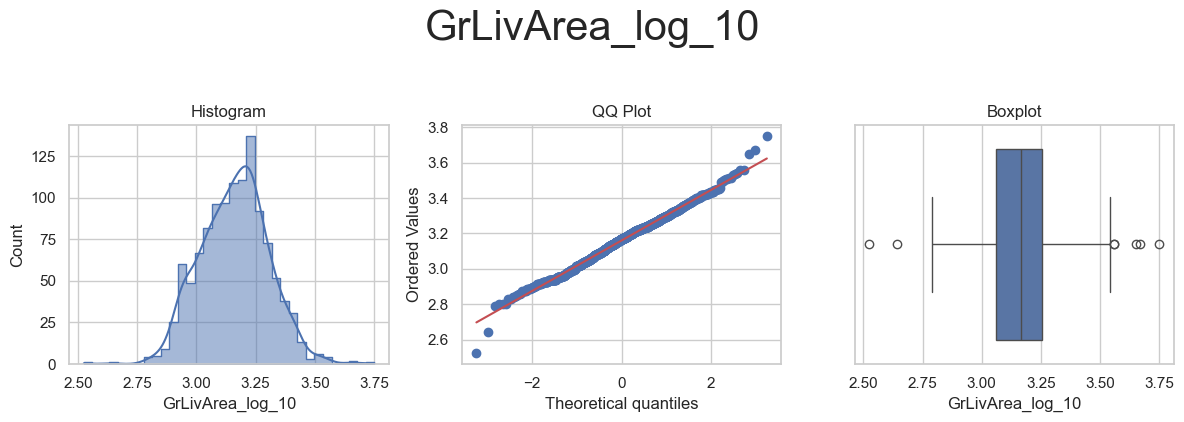

skewness: 0.01 | kurtosis: 0.35




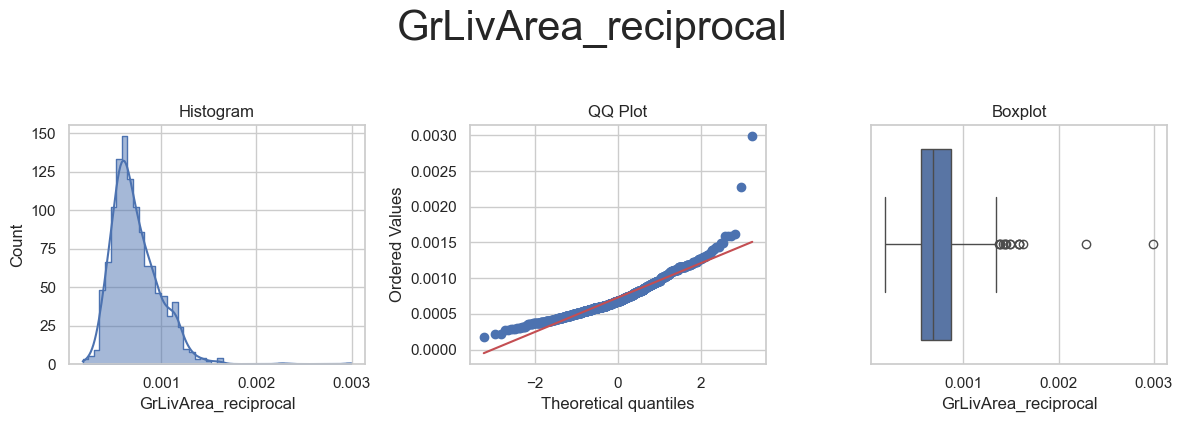

skewness: 1.44 | kurtosis: 6.75




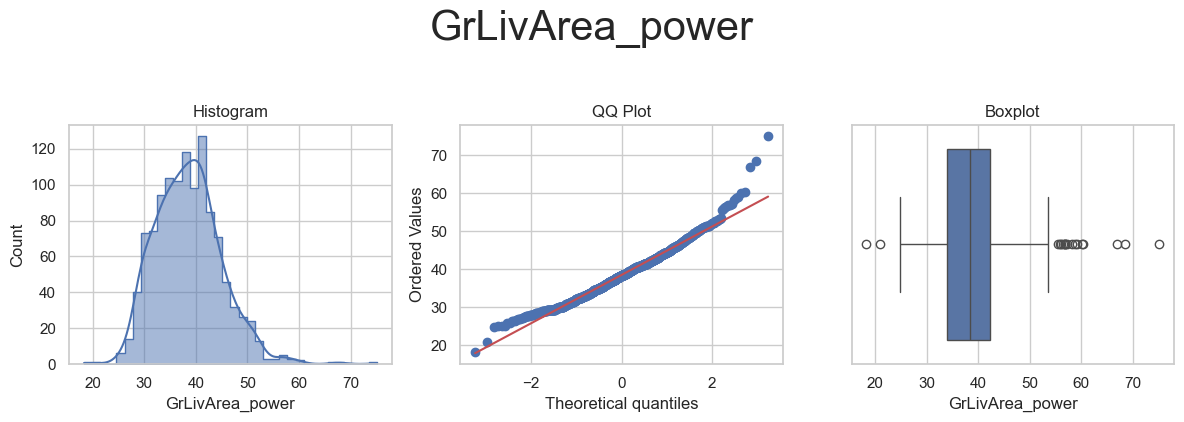

skewness: 0.62 | kurtosis: 1.39




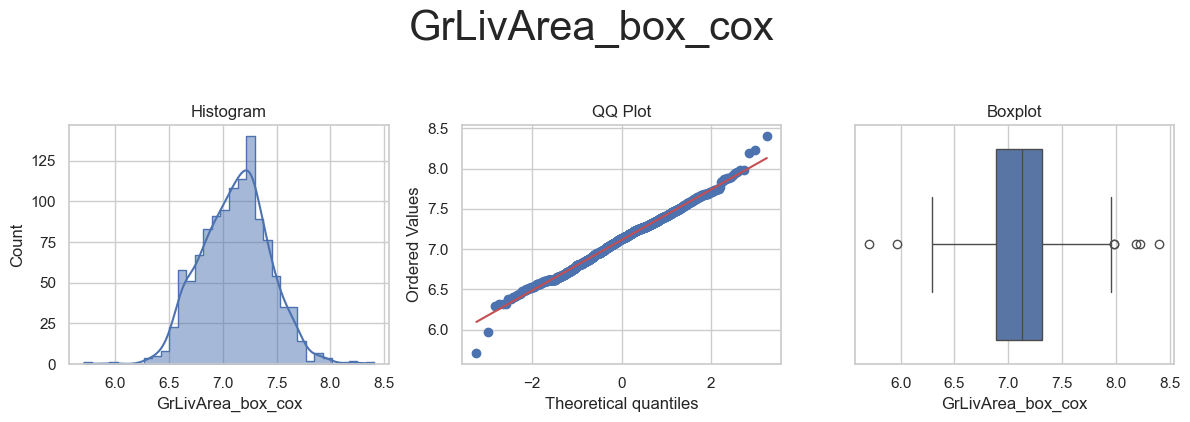

skewness: -0.0 | kurtosis: 0.35




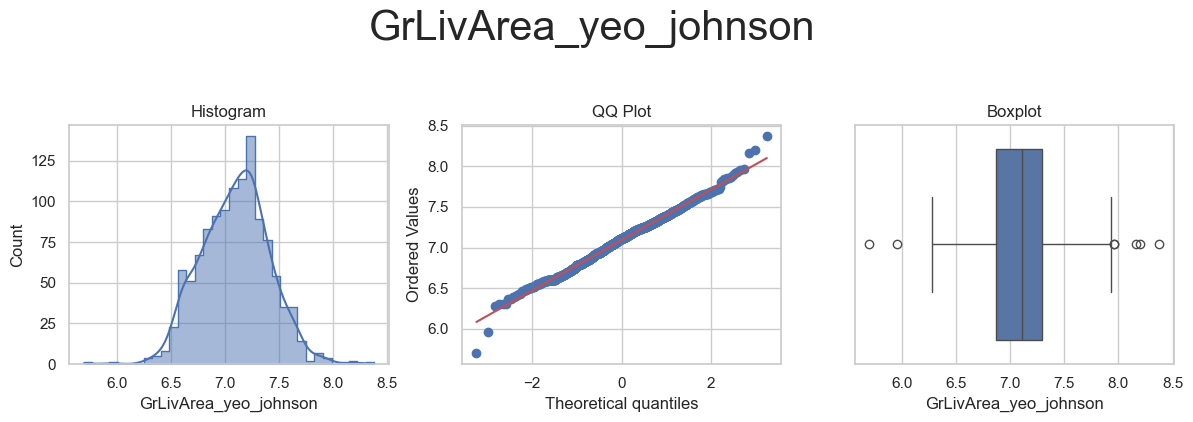

skewness: -0.0 | kurtosis: 0.35


* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



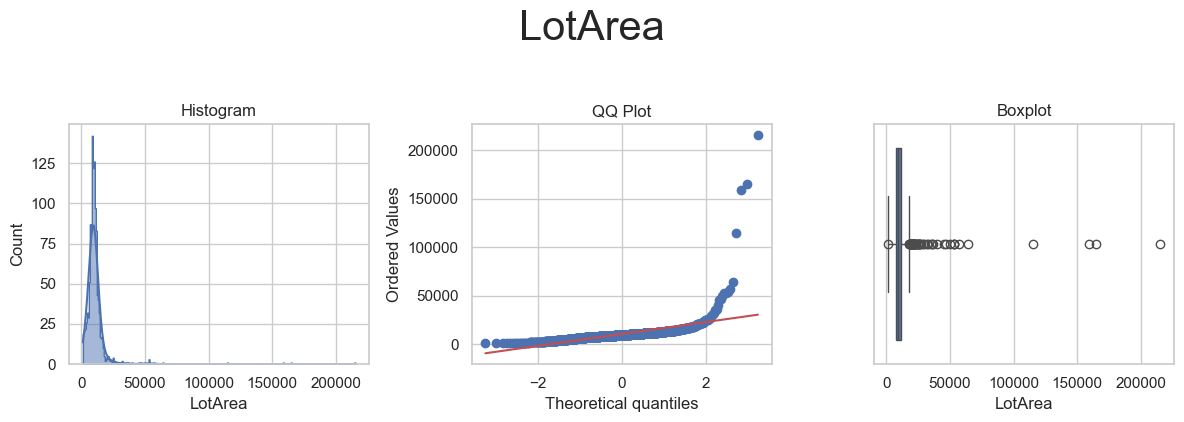

skewness: 11.96 | kurtosis: 186.44




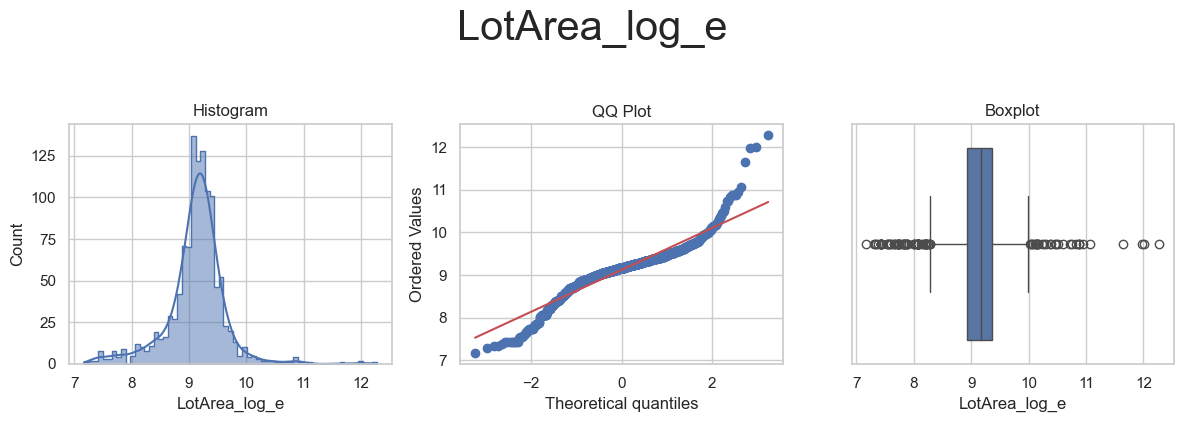

skewness: -0.01 | kurtosis: 5.2




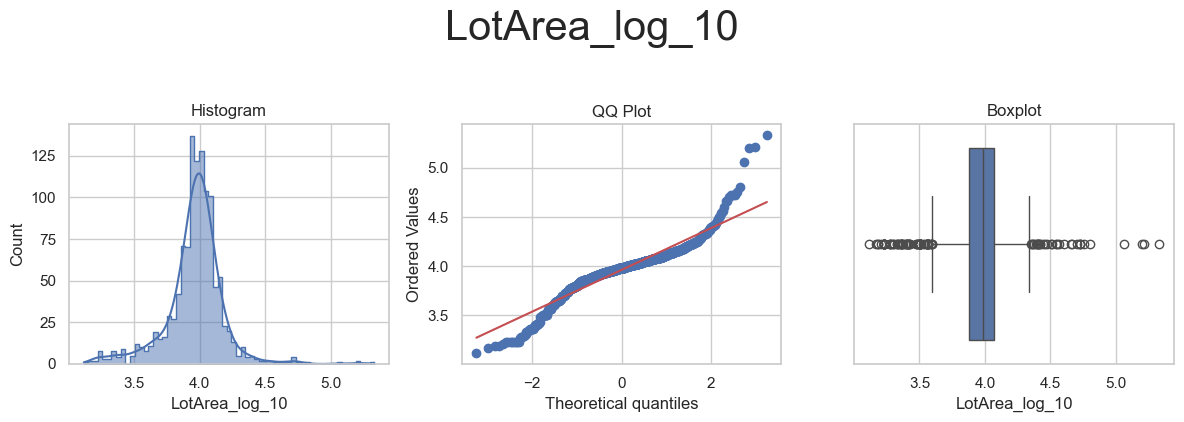

skewness: -0.01 | kurtosis: 5.2




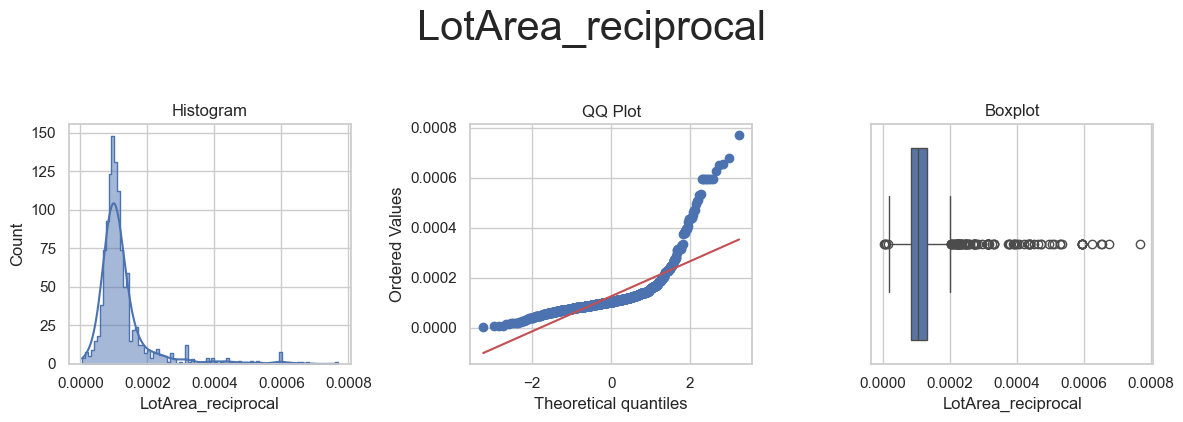

skewness: 3.44 | kurtosis: 14.63




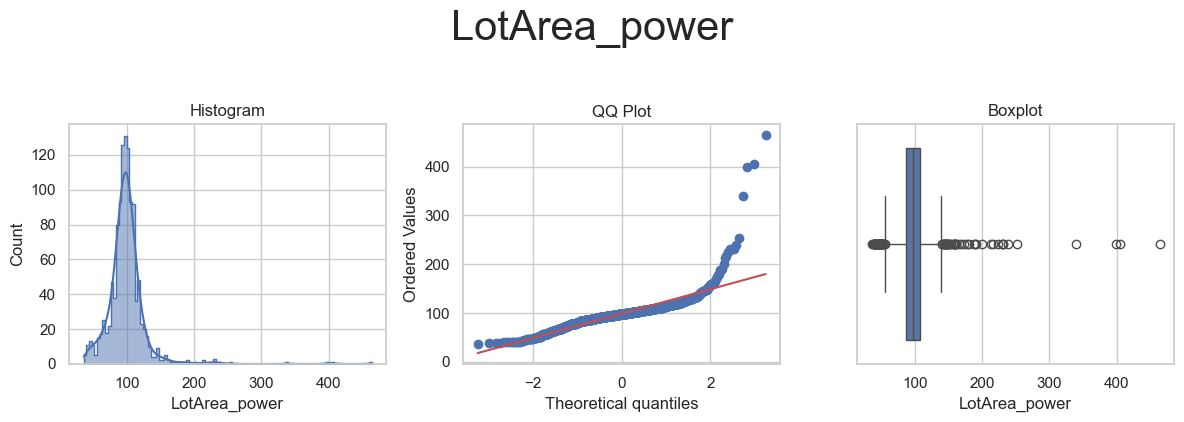

skewness: 4.48 | kurtosis: 43.28




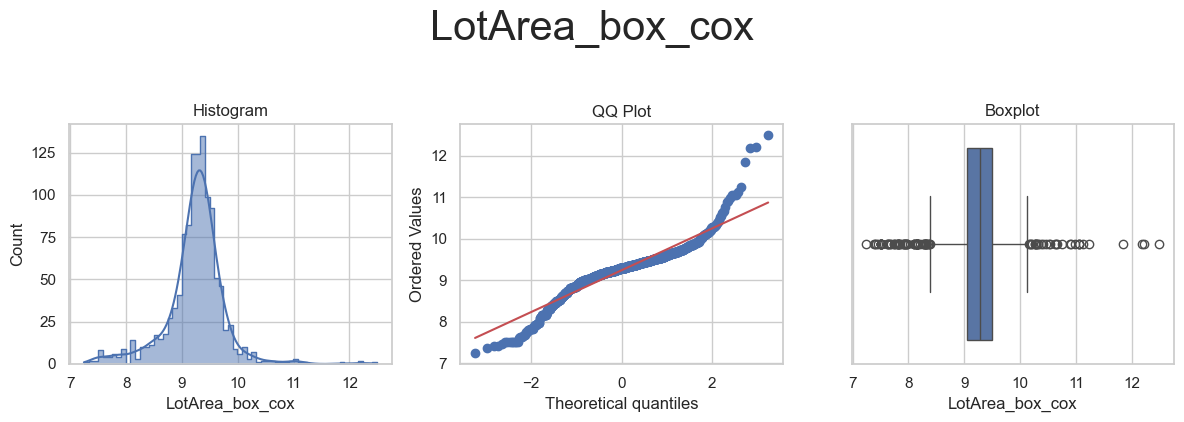

skewness: 0.0 | kurtosis: 5.24




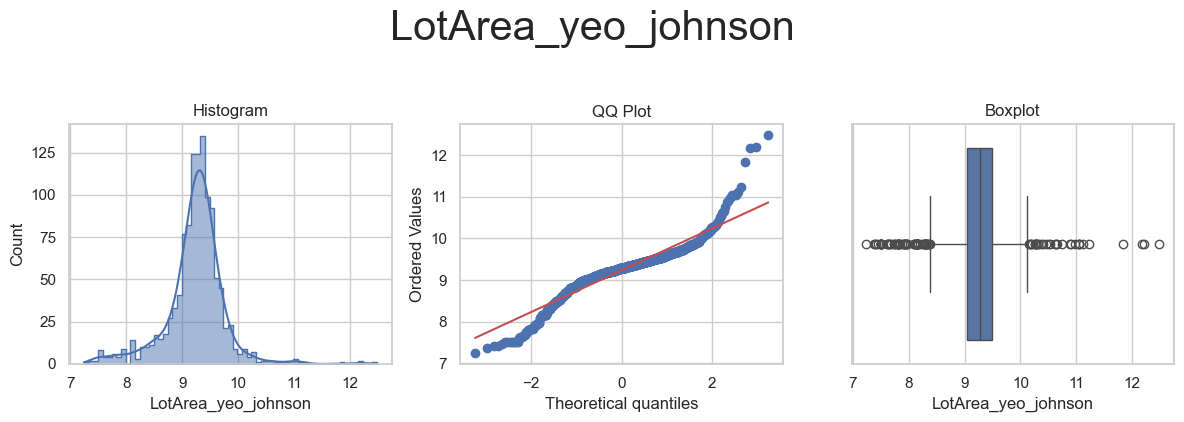

skewness: 0.0 | kurtosis: 5.24


* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



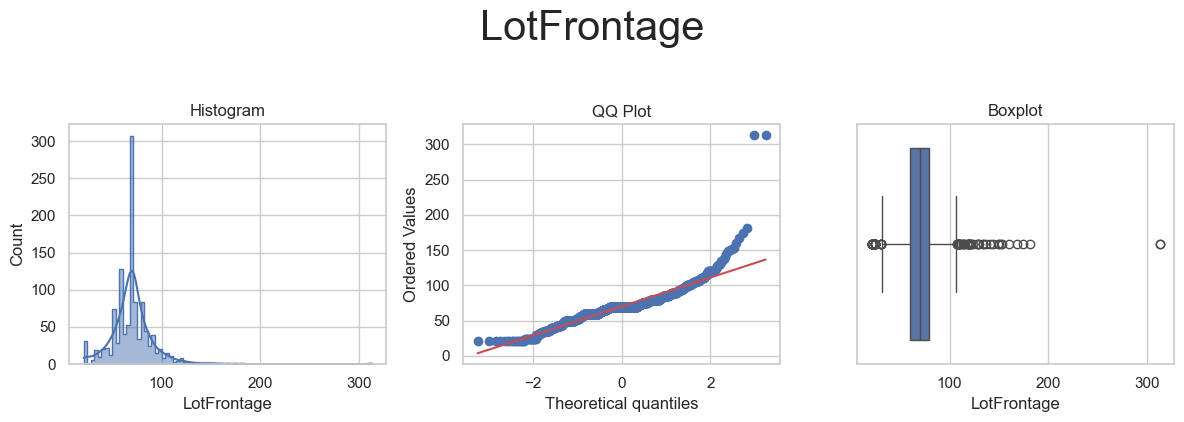

skewness: 2.67 | kurtosis: 24.58




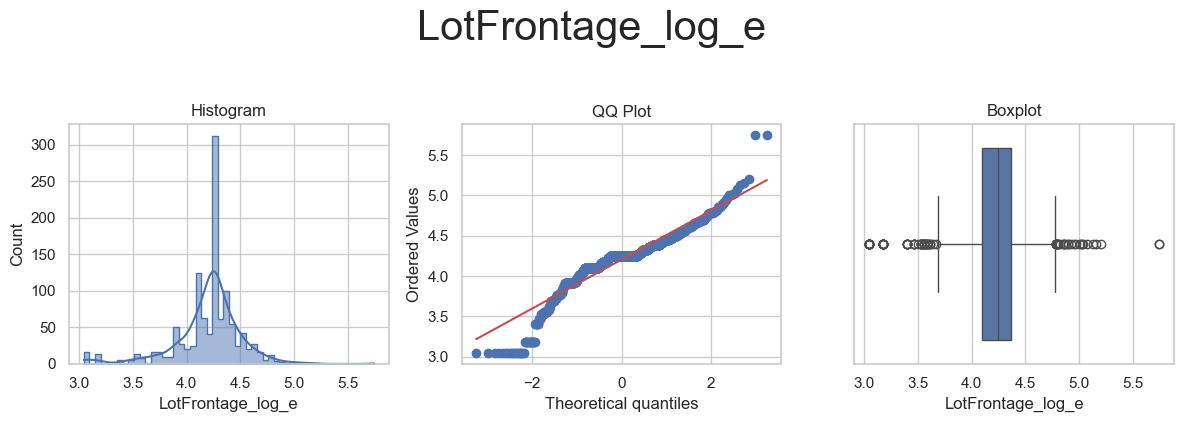

skewness: -0.85 | kurtosis: 3.6




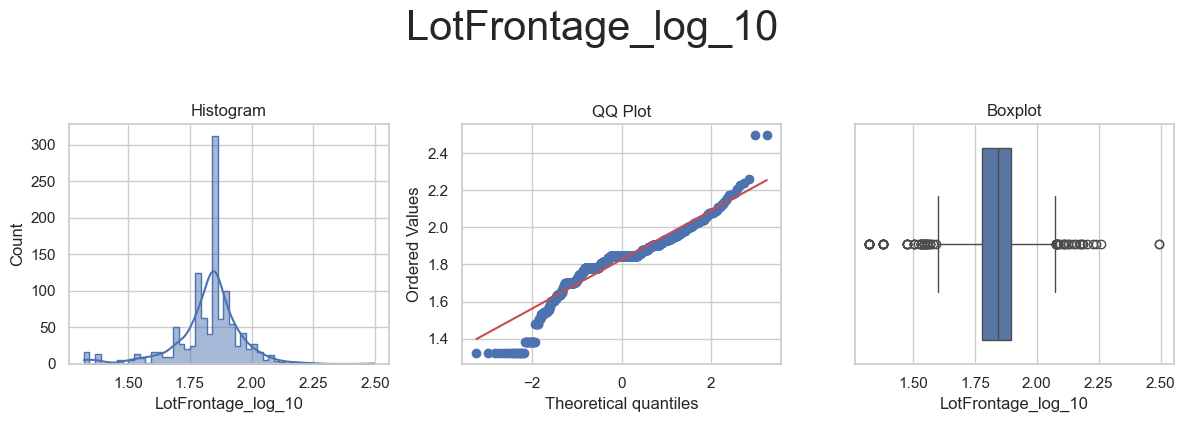

skewness: -0.85 | kurtosis: 3.6




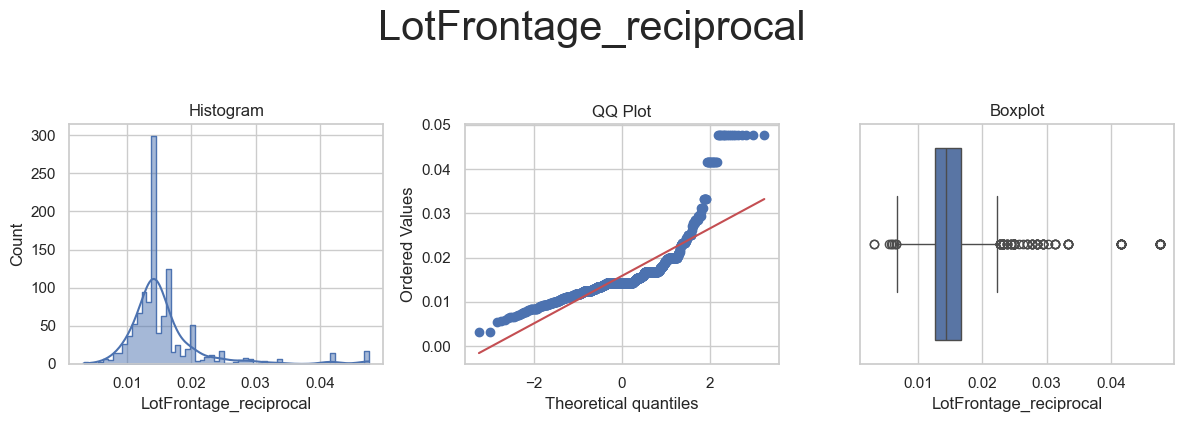

skewness: 2.86 | kurtosis: 10.42




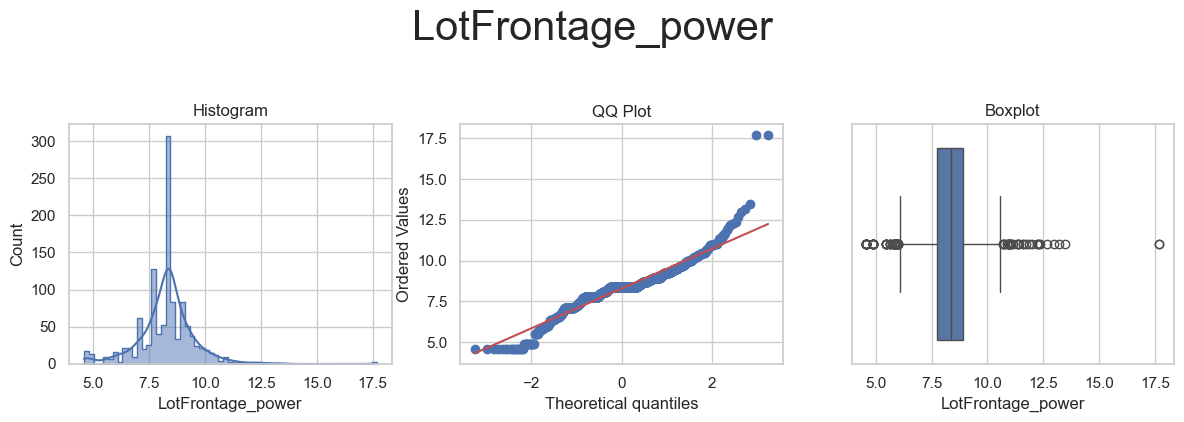

skewness: 0.51 | kurtosis: 6.33




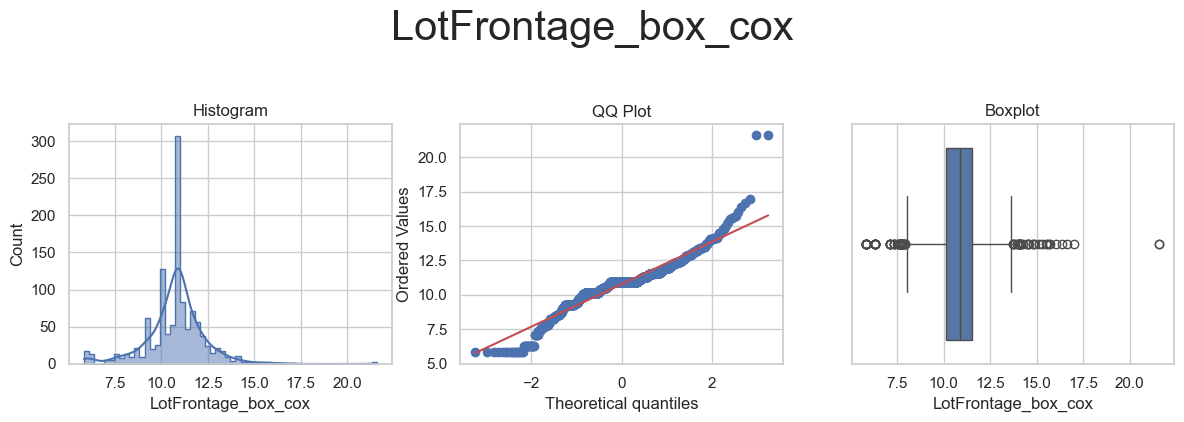

skewness: 0.17 | kurtosis: 4.97




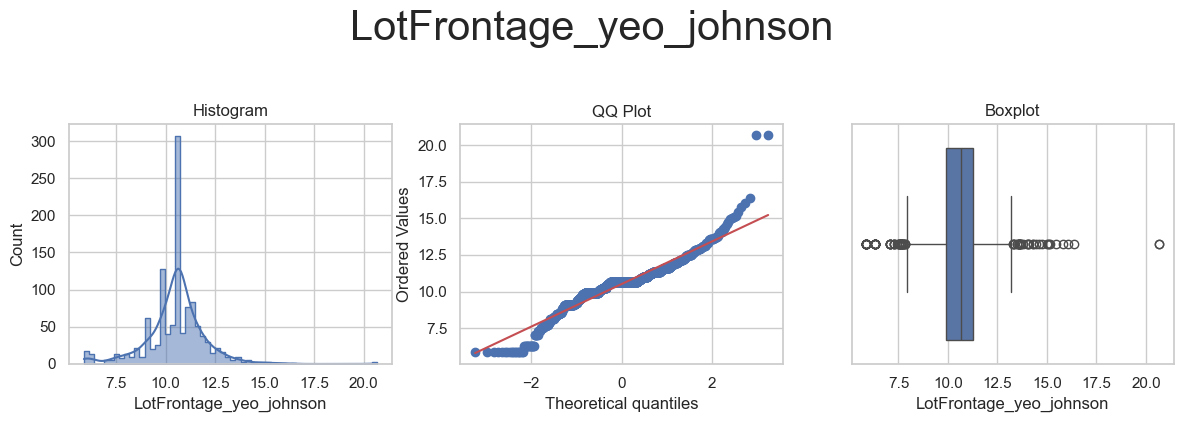

skewness: 0.16 | kurtosis: 4.91


* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



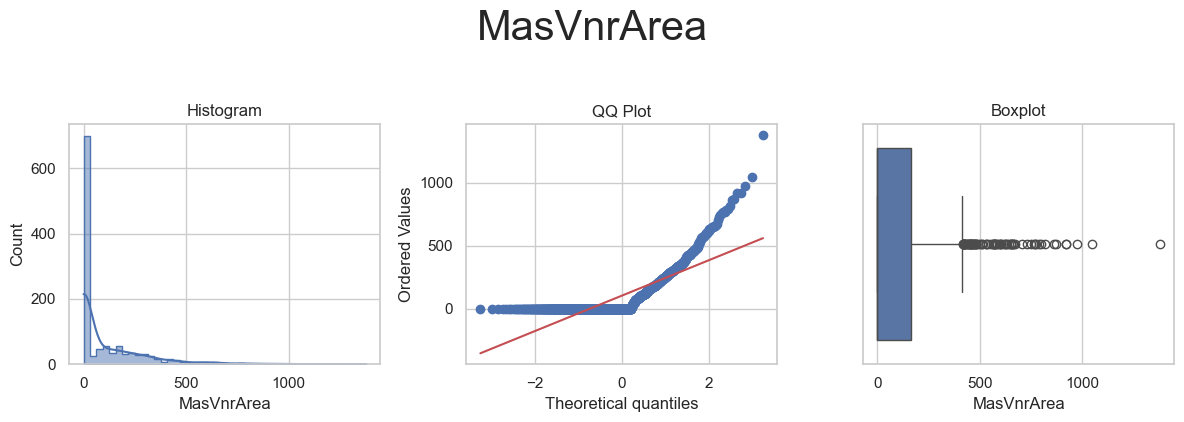

skewness: 2.29 | kurtosis: 6.72




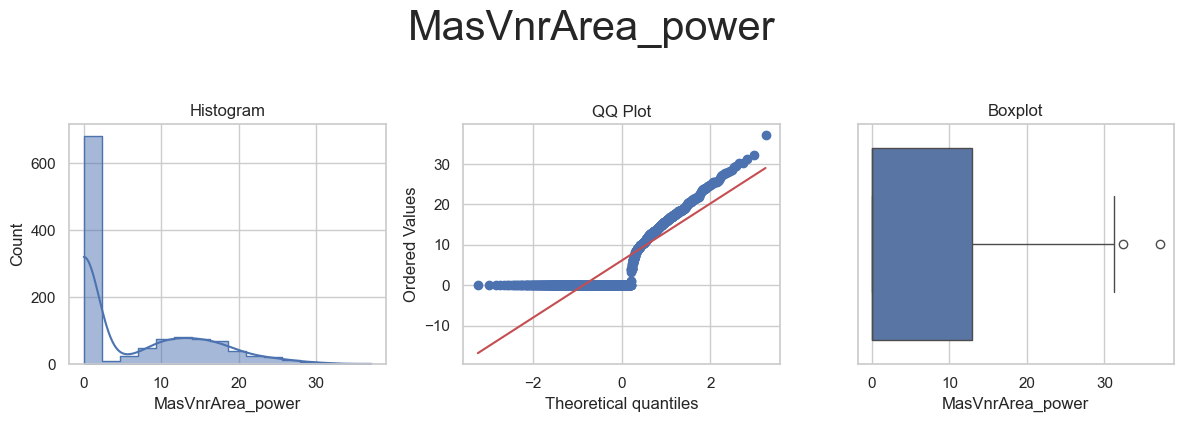

skewness: 0.96 | kurtosis: -0.27




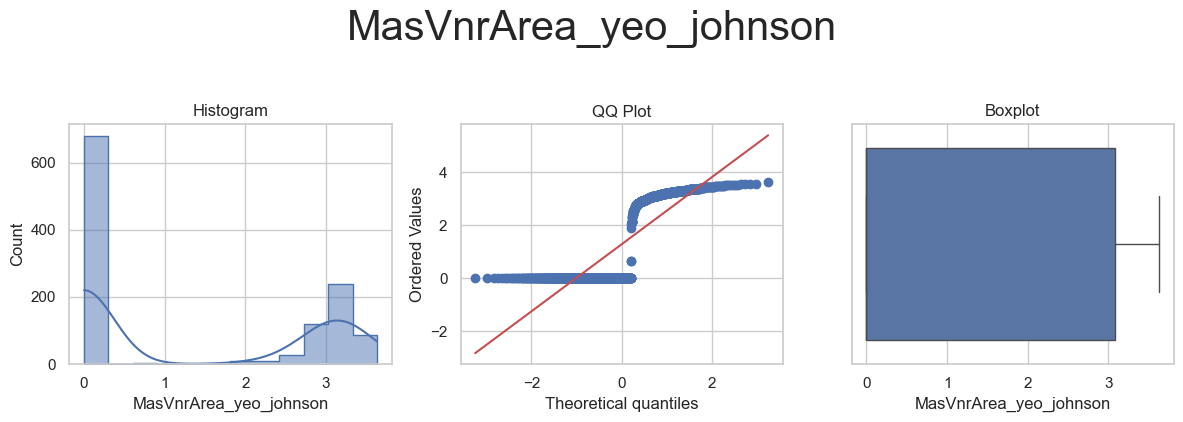

skewness: 0.38 | kurtosis: -1.81


* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



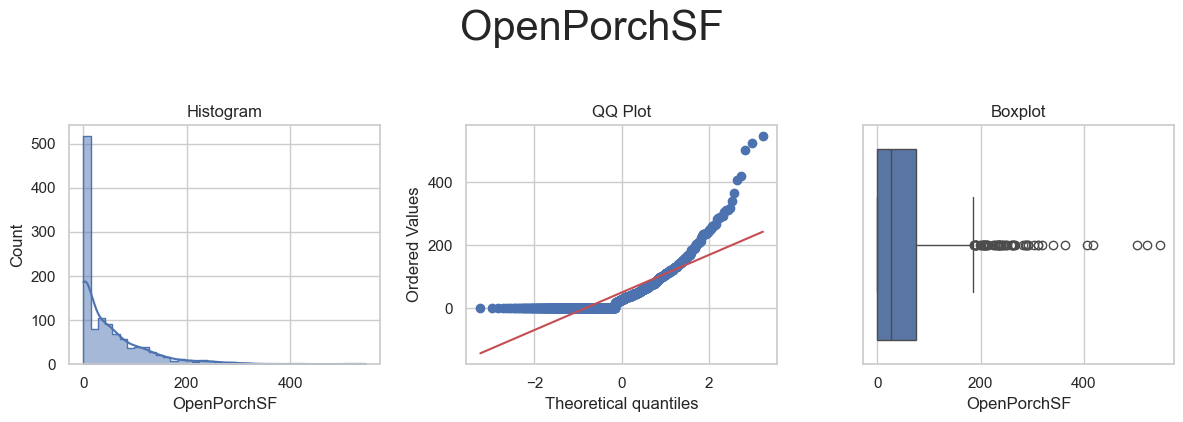

skewness: 2.33 | kurtosis: 8.15




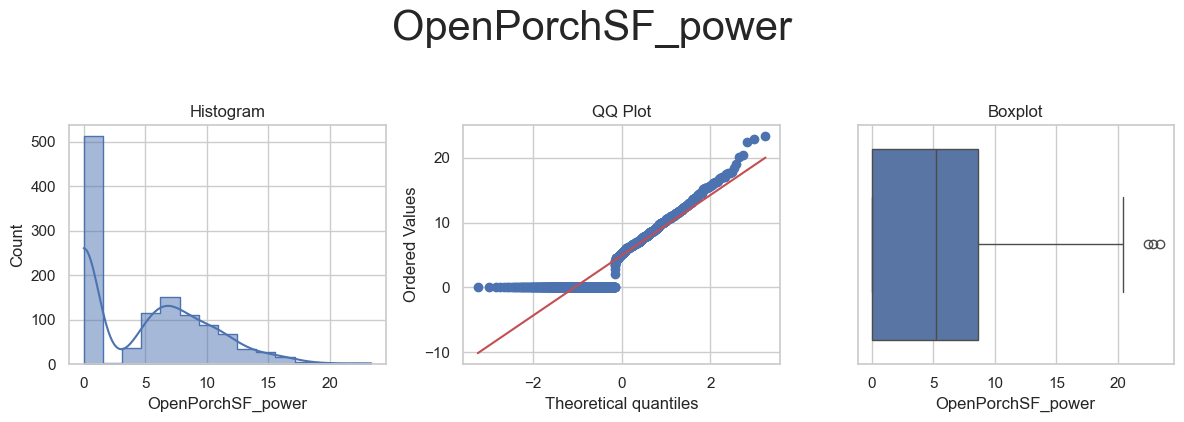

skewness: 0.57 | kurtosis: -0.55




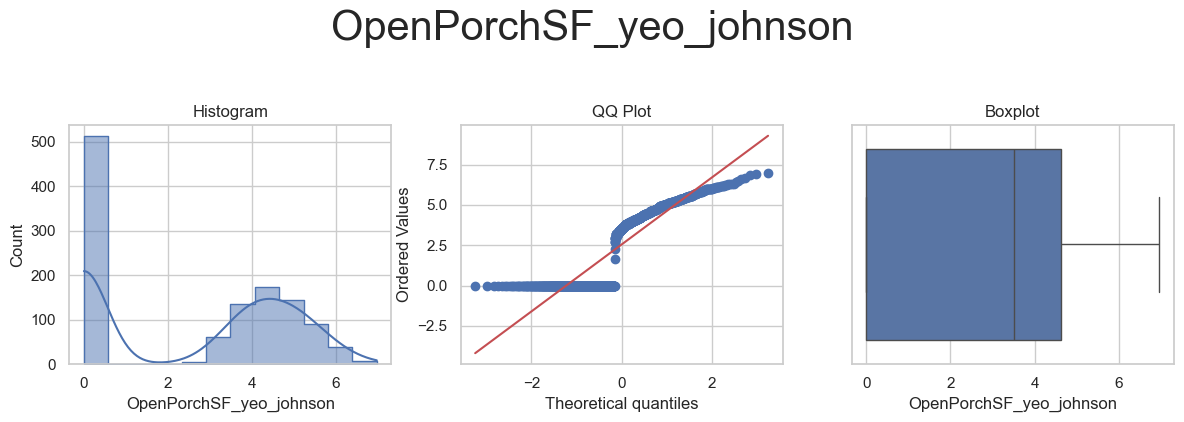

skewness: -0.04 | kurtosis: -1.74


* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



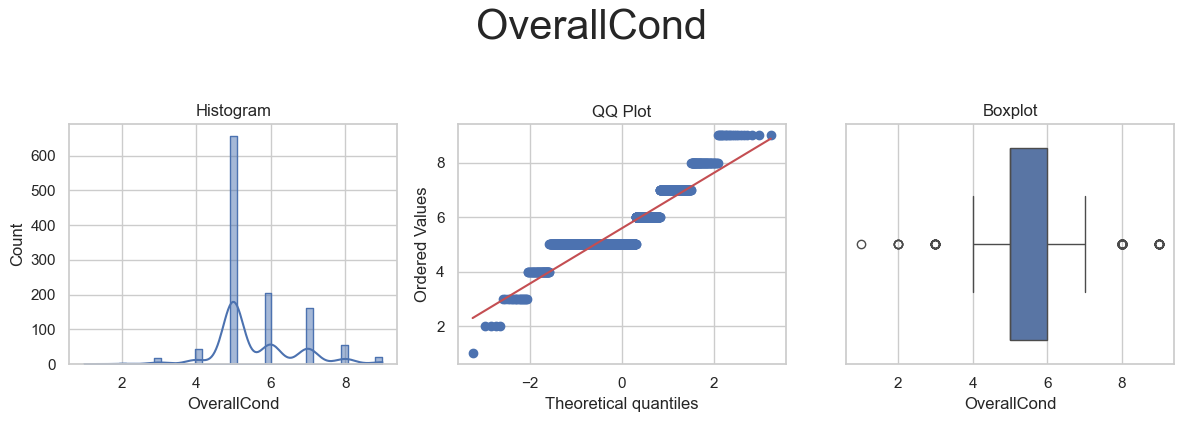

skewness: 0.73 | kurtosis: 1.24




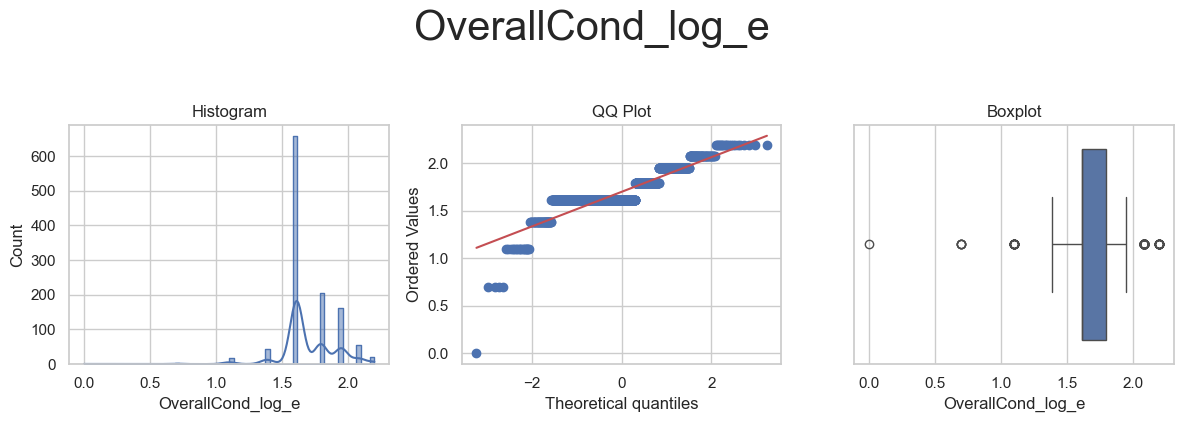

skewness: -0.69 | kurtosis: 6.39




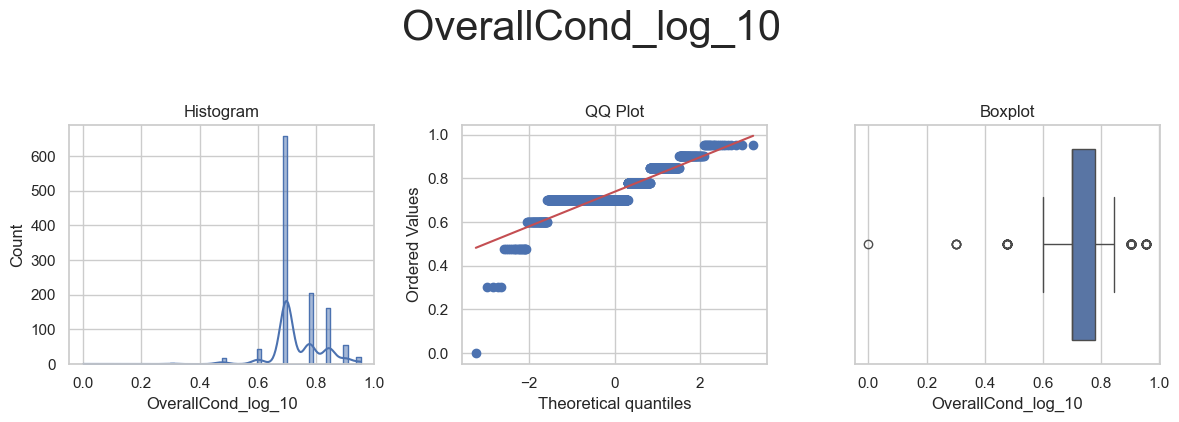

skewness: -0.69 | kurtosis: 6.39




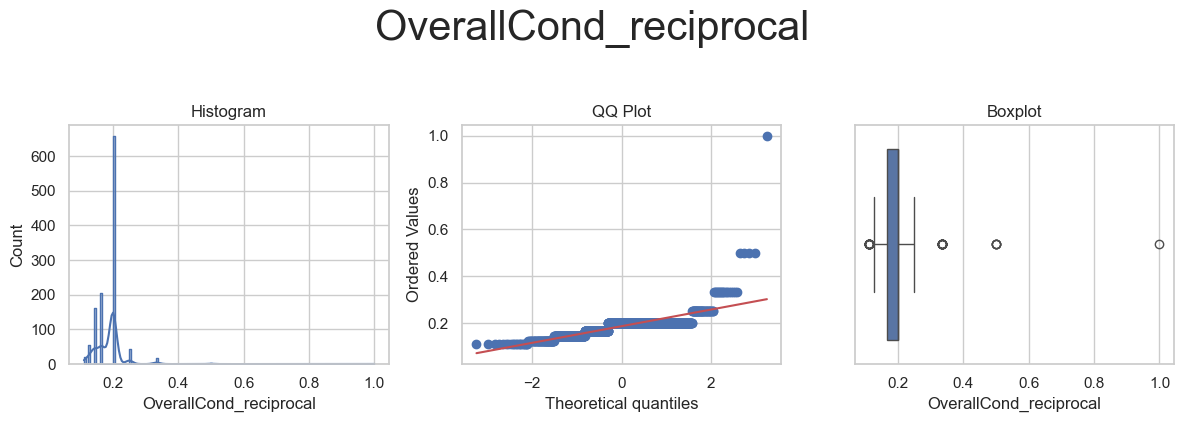

skewness: 6.16 | kurtosis: 91.65




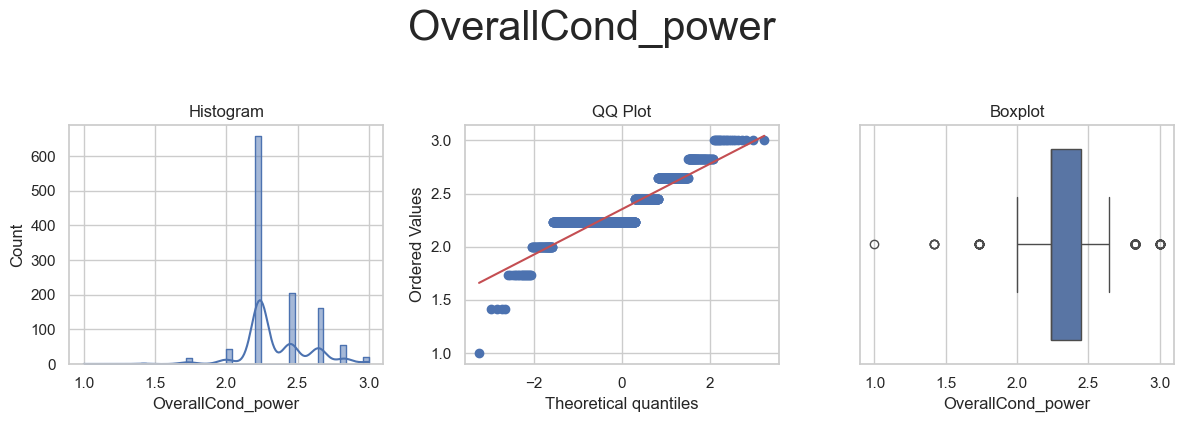

skewness: 0.2 | kurtosis: 2.08




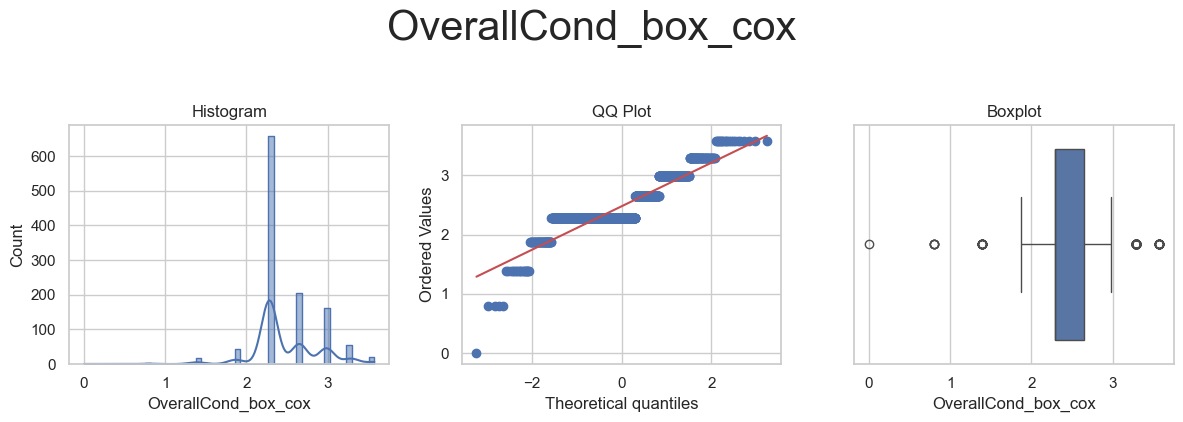

skewness: 0.08 | kurtosis: 2.46




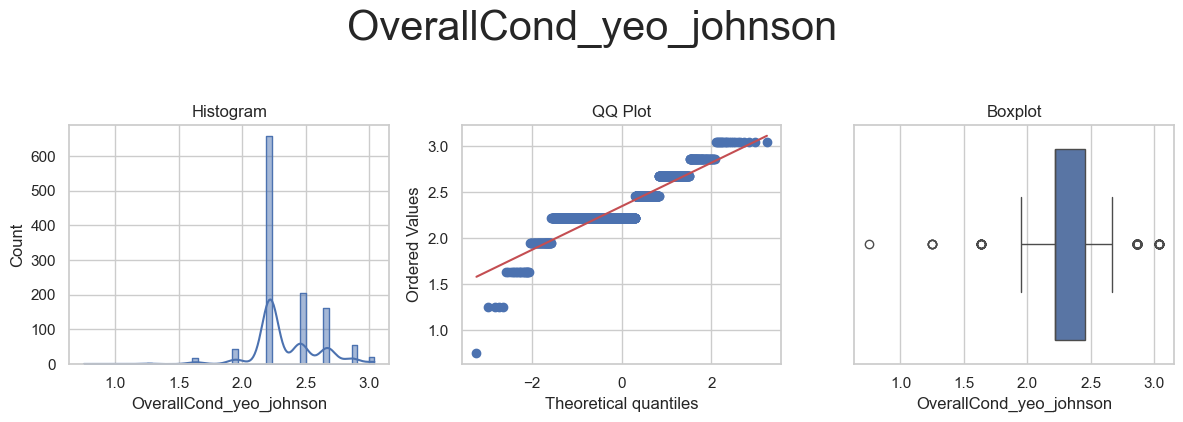

skewness: 0.04 | kurtosis: 2.5


* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



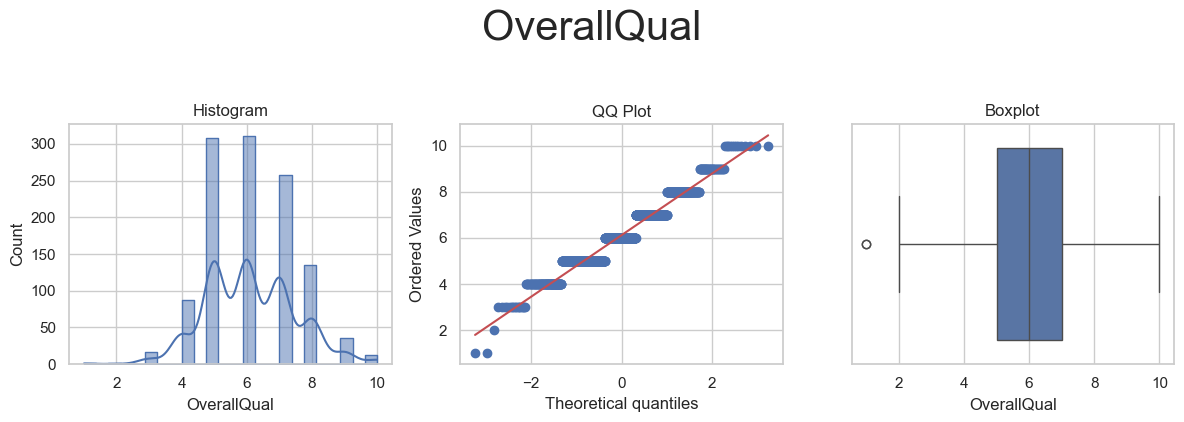

skewness: 0.2 | kurtosis: 0.12




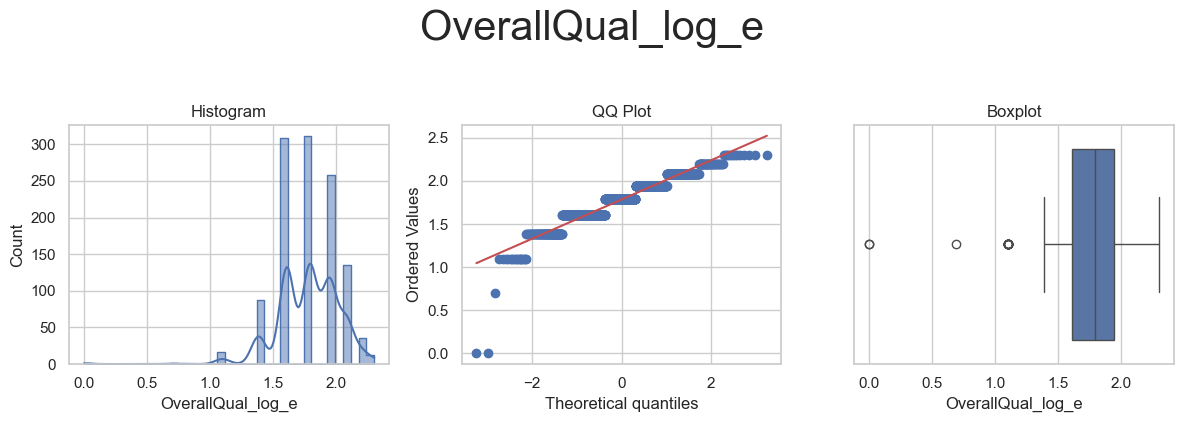

skewness: -1.02 | kurtosis: 5.18




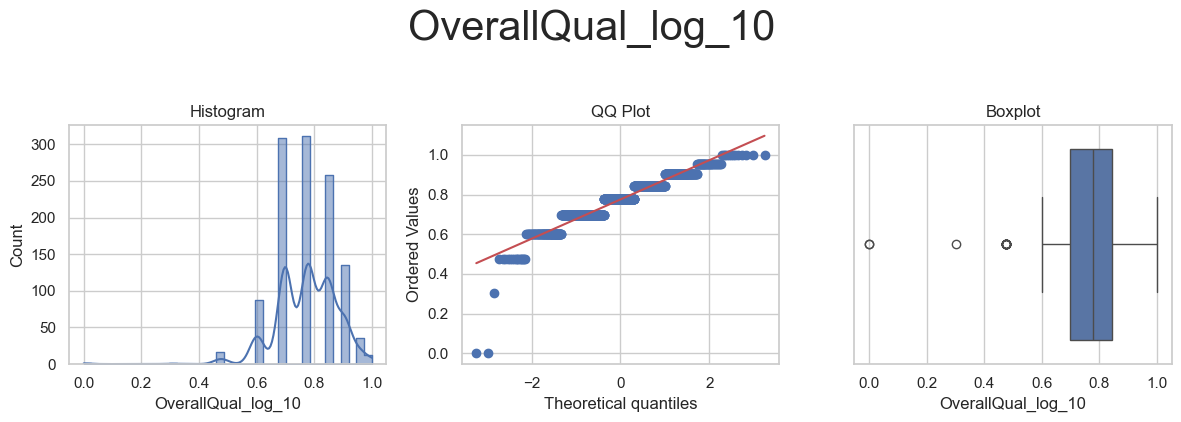

skewness: -1.02 | kurtosis: 5.18




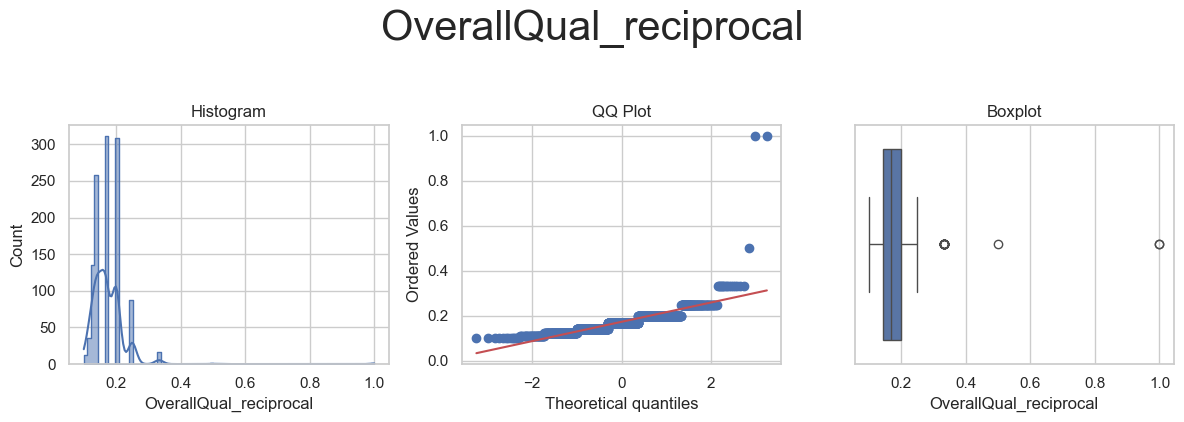

skewness: 6.78 | kurtosis: 94.72




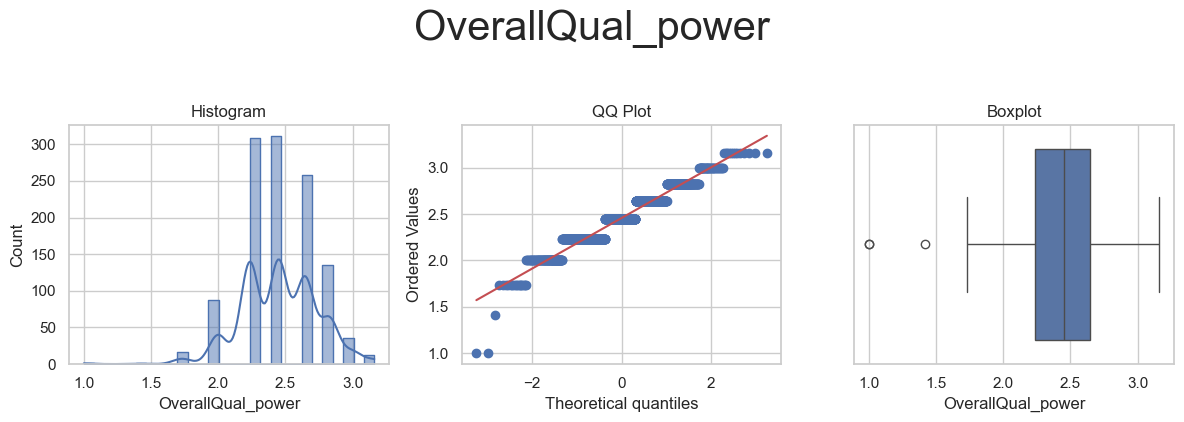

skewness: -0.25 | kurtosis: 0.93




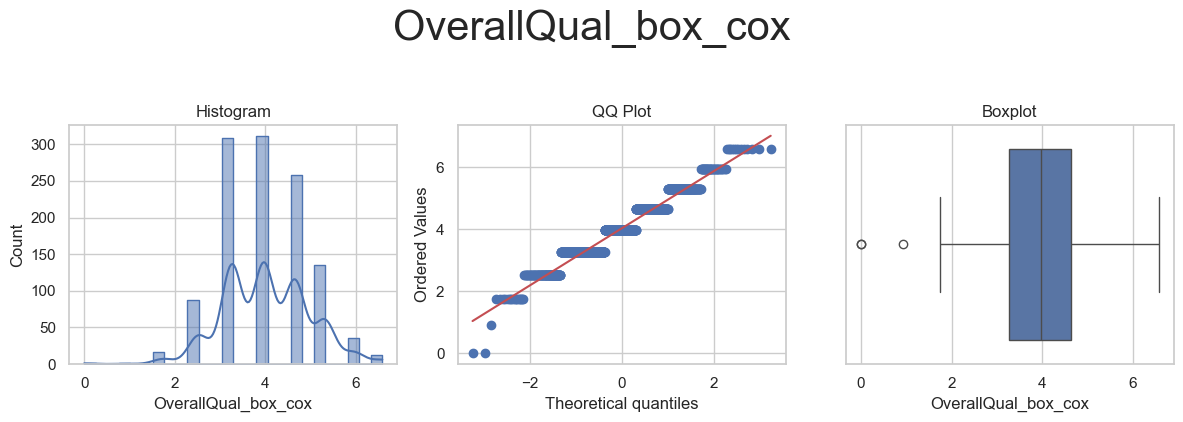

skewness: 0.03 | kurtosis: 0.28




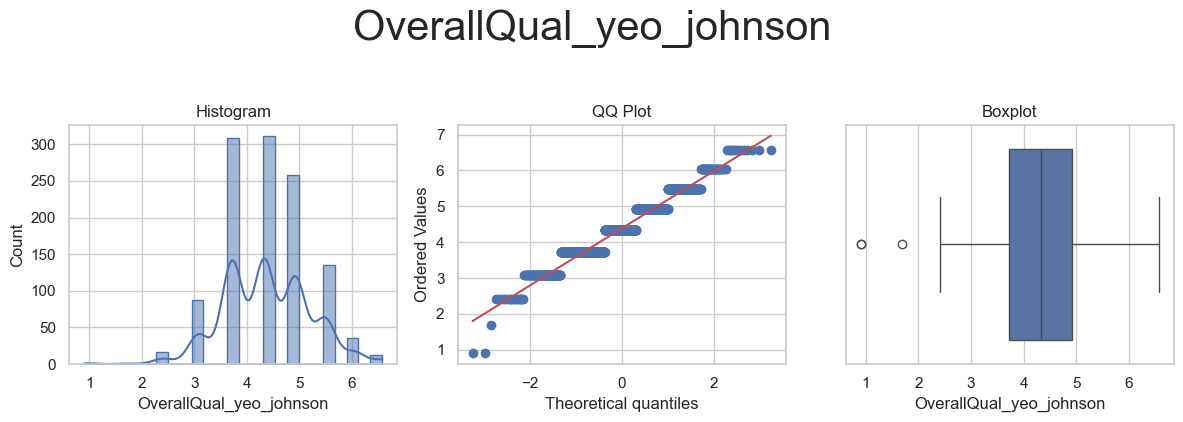

skewness: 0.02 | kurtosis: 0.27


* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



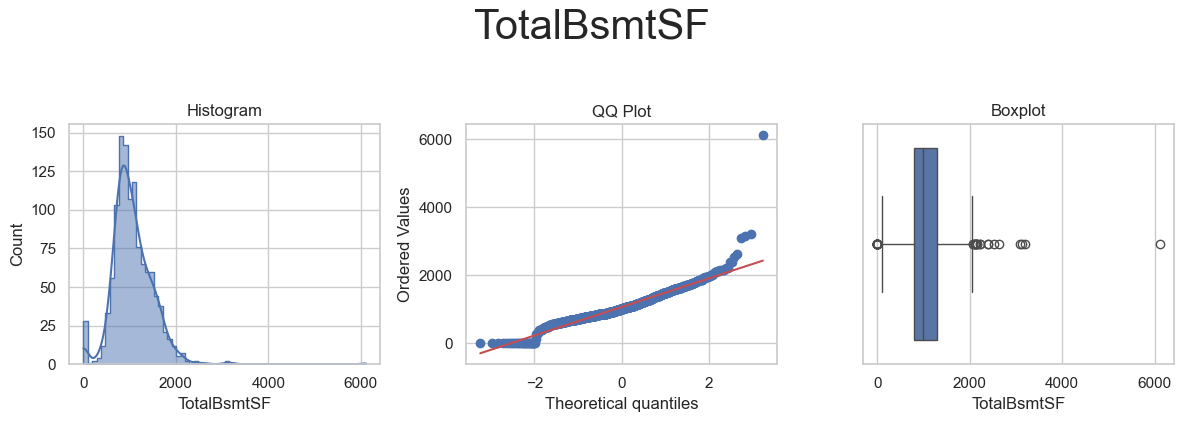

skewness: 1.72 | kurtosis: 15.68




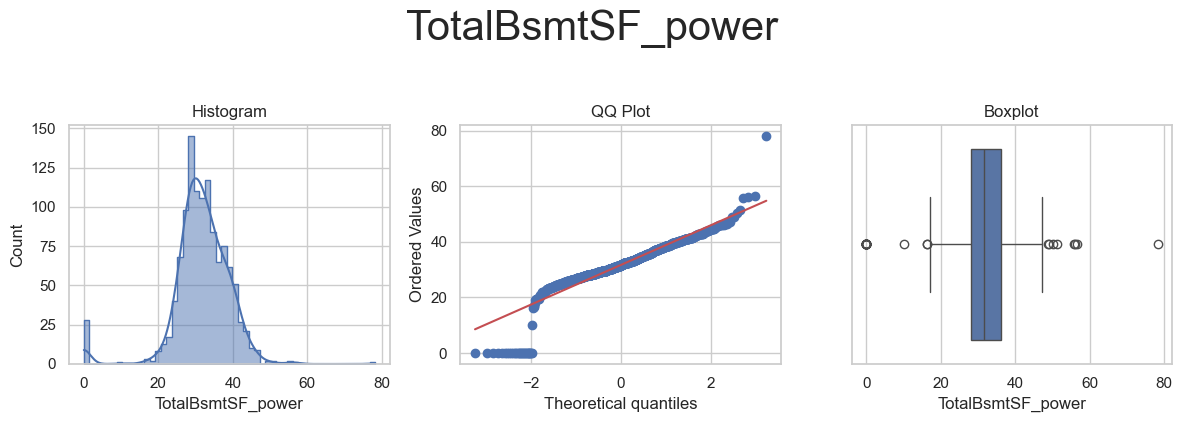

skewness: -1.21 | kurtosis: 6.54




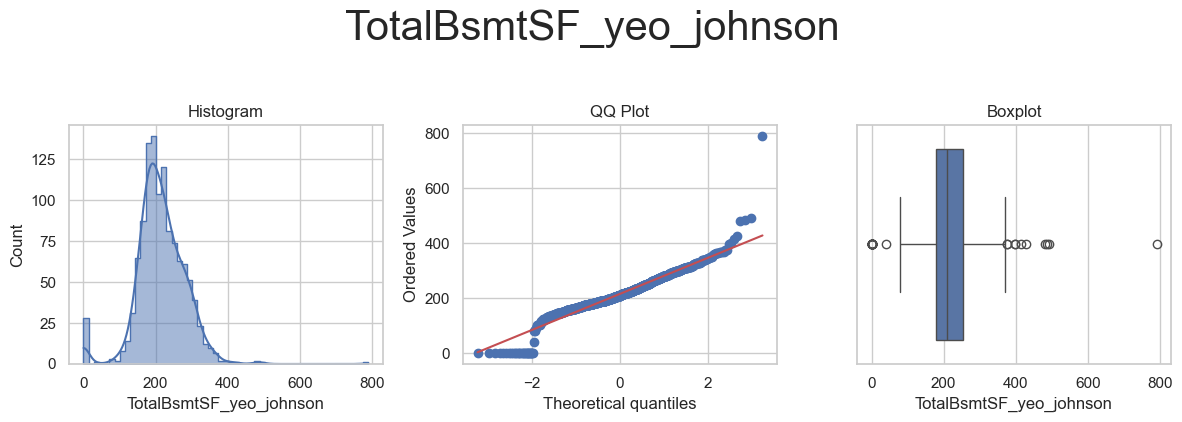

skewness: 0.29 | kurtosis: 6.03


* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



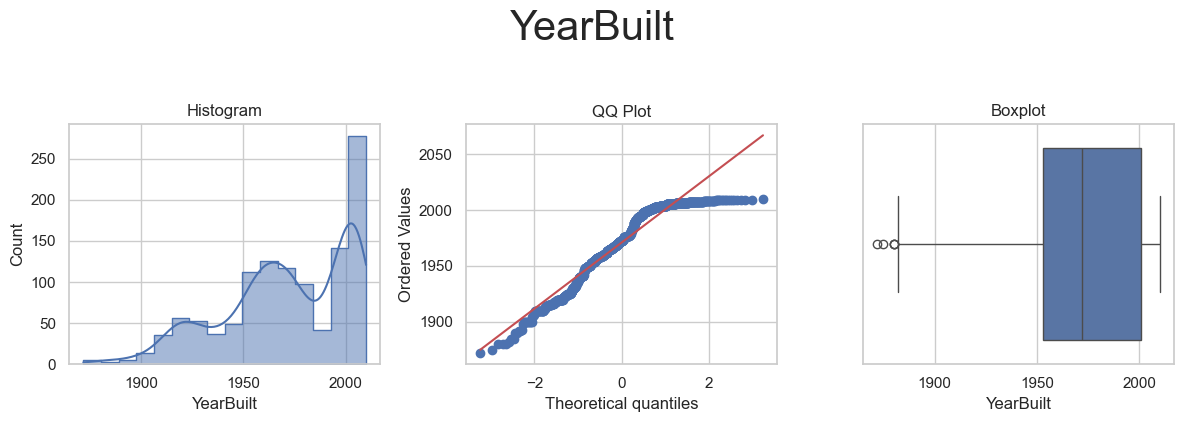

skewness: -0.62 | kurtosis: -0.43




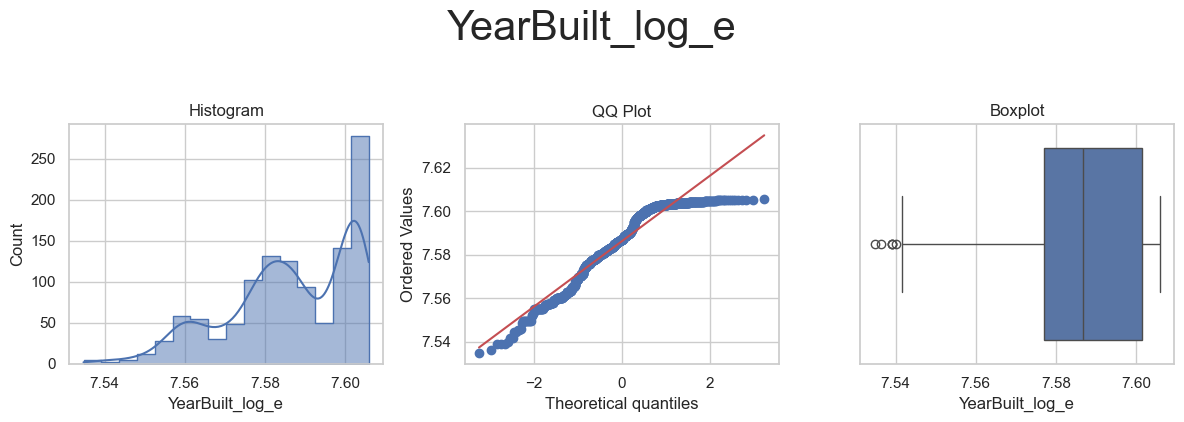

skewness: -0.65 | kurtosis: -0.37




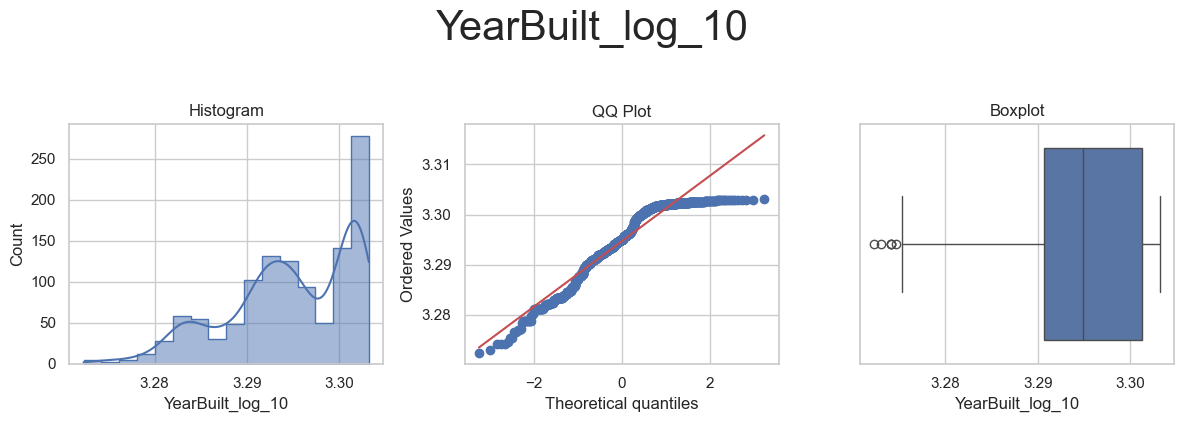

skewness: -0.65 | kurtosis: -0.37




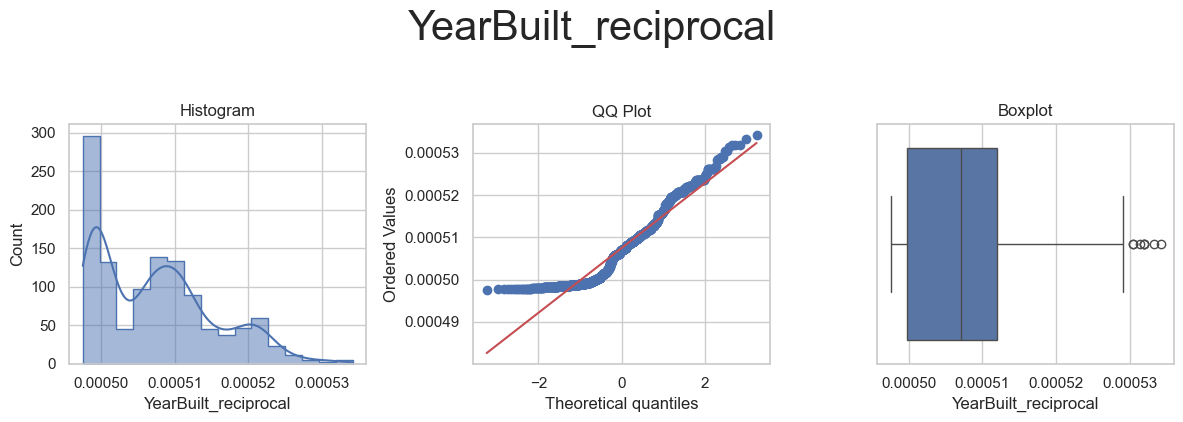

skewness: 0.68 | kurtosis: -0.31




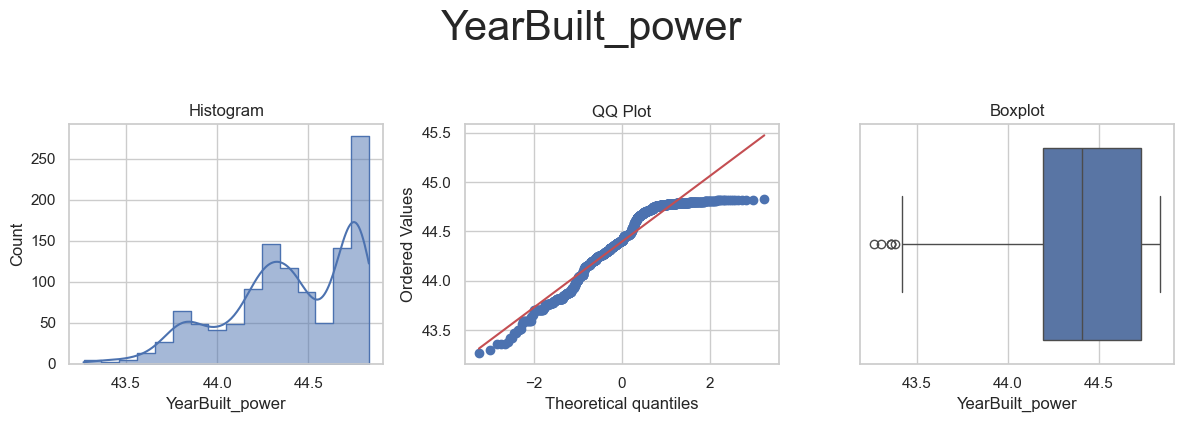

skewness: -0.64 | kurtosis: -0.4




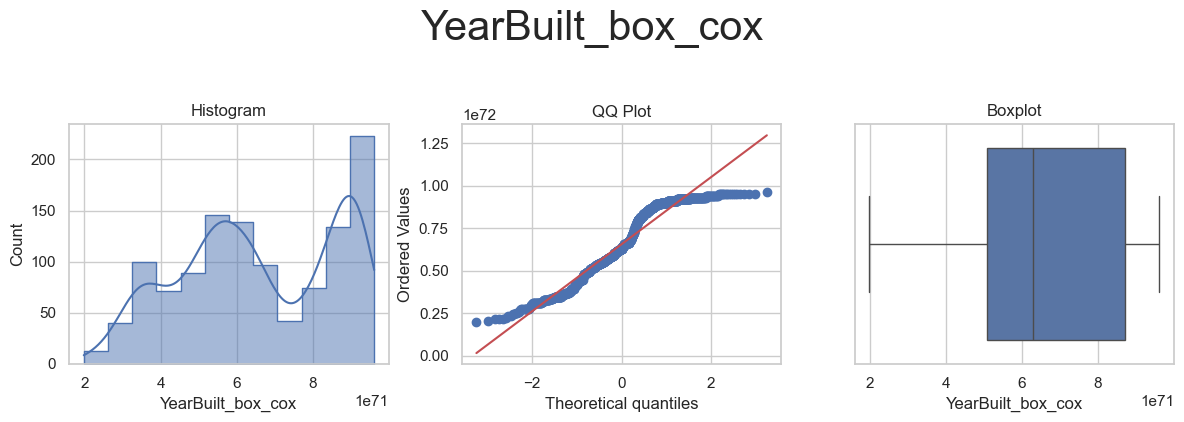

skewness: -0.14 | kurtosis: -1.2




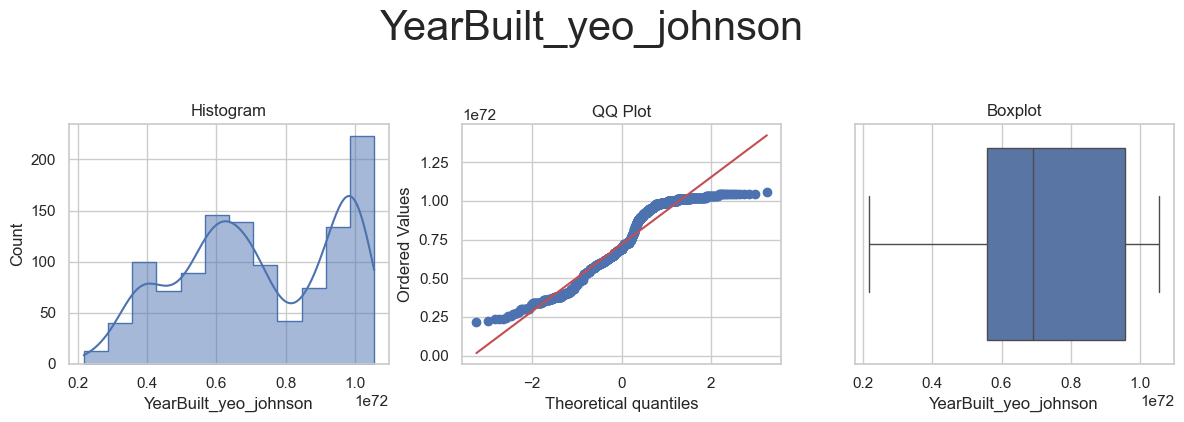

skewness: -0.14 | kurtosis: -1.2


* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



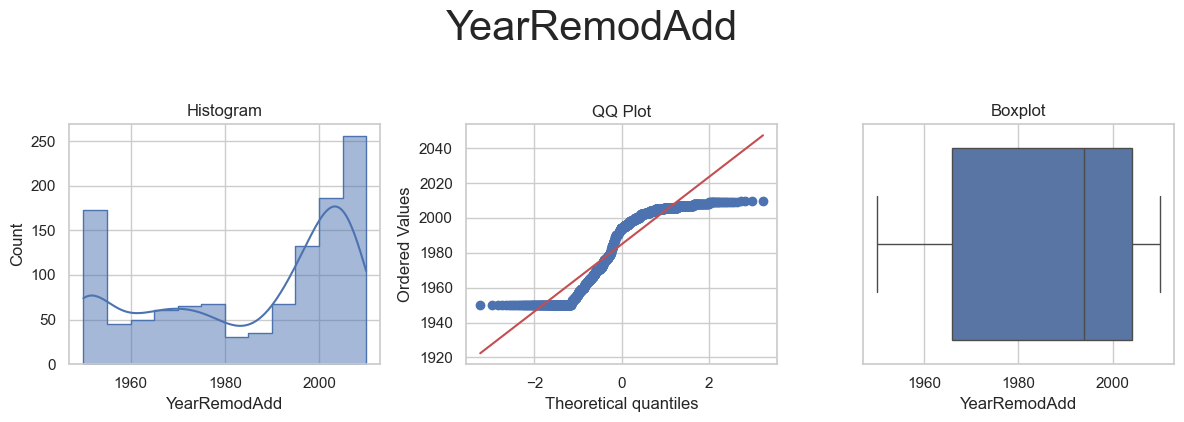

skewness: -0.51 | kurtosis: -1.28




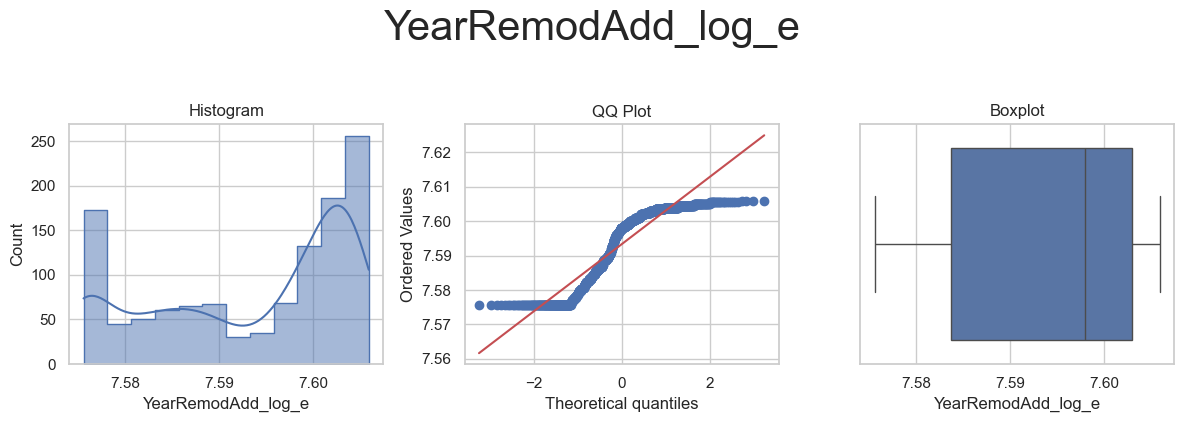

skewness: -0.52 | kurtosis: -1.27




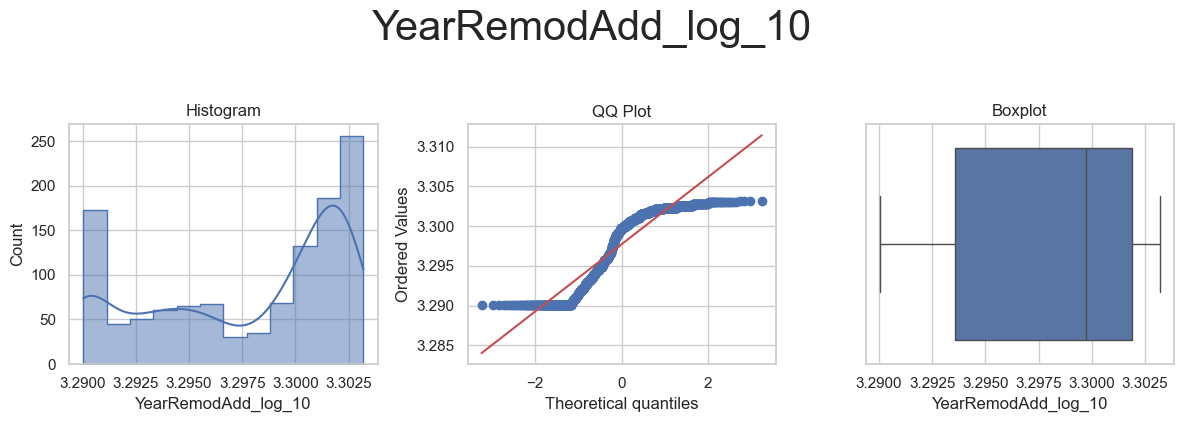

skewness: -0.52 | kurtosis: -1.27




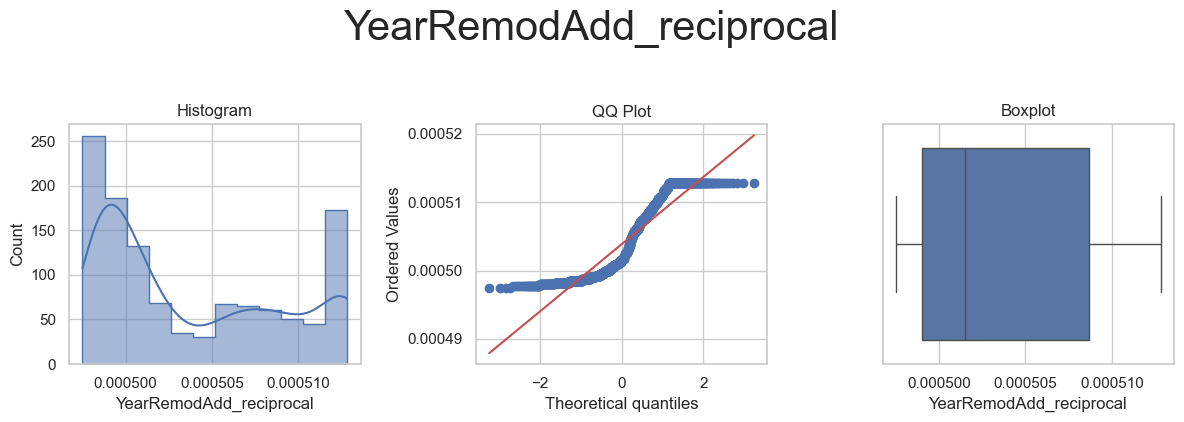

skewness: 0.52 | kurtosis: -1.26




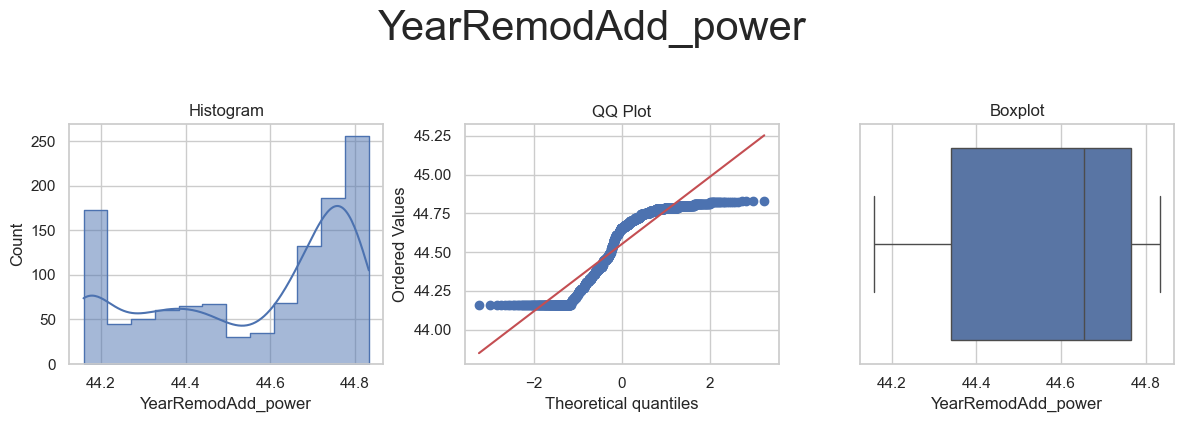

skewness: -0.51 | kurtosis: -1.28




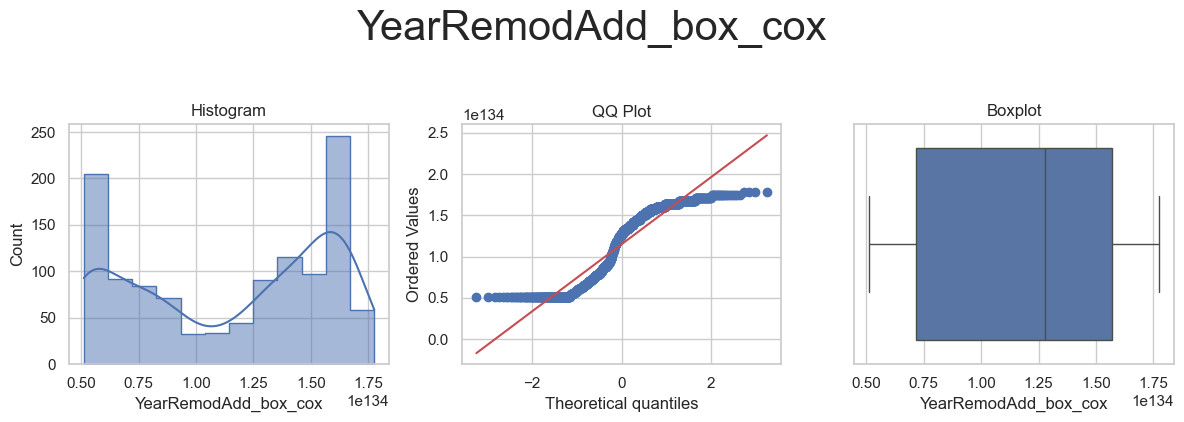

skewness: nan | kurtosis: nan




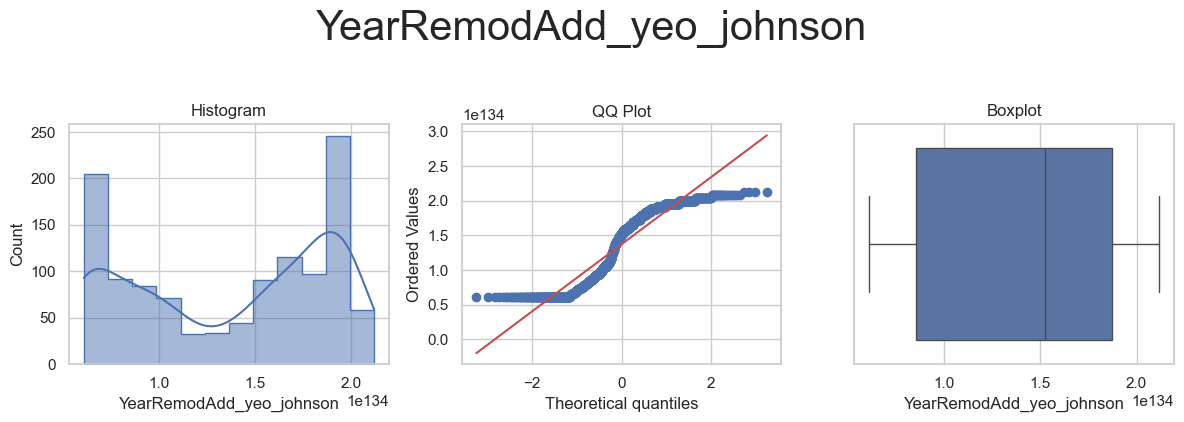

skewness: nan | kurtosis: nan


* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



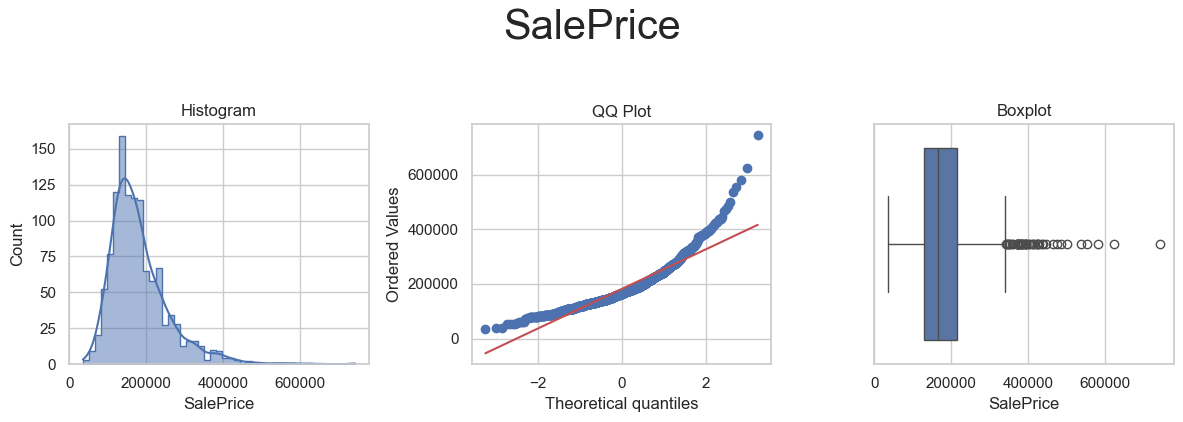

skewness: 1.74 | kurtosis: 5.48




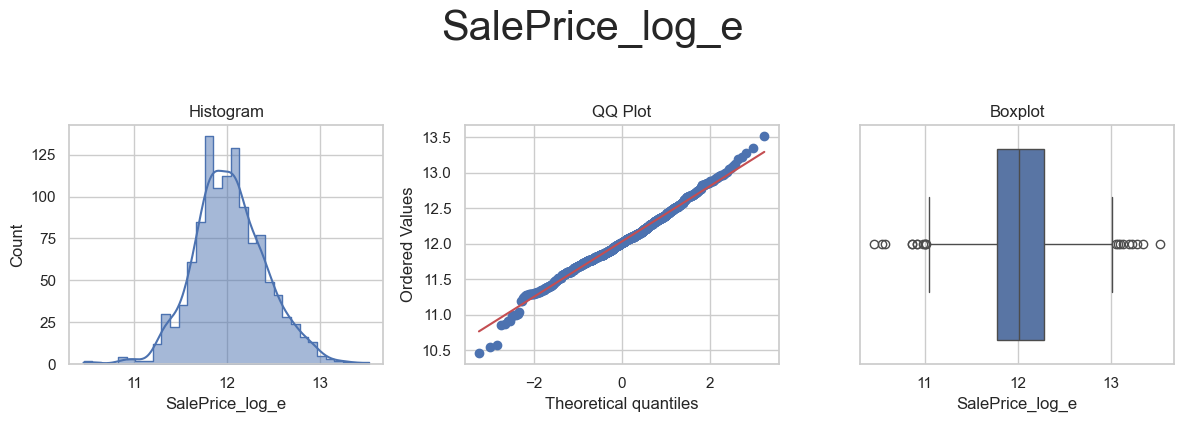

skewness: 0.12 | kurtosis: 0.7




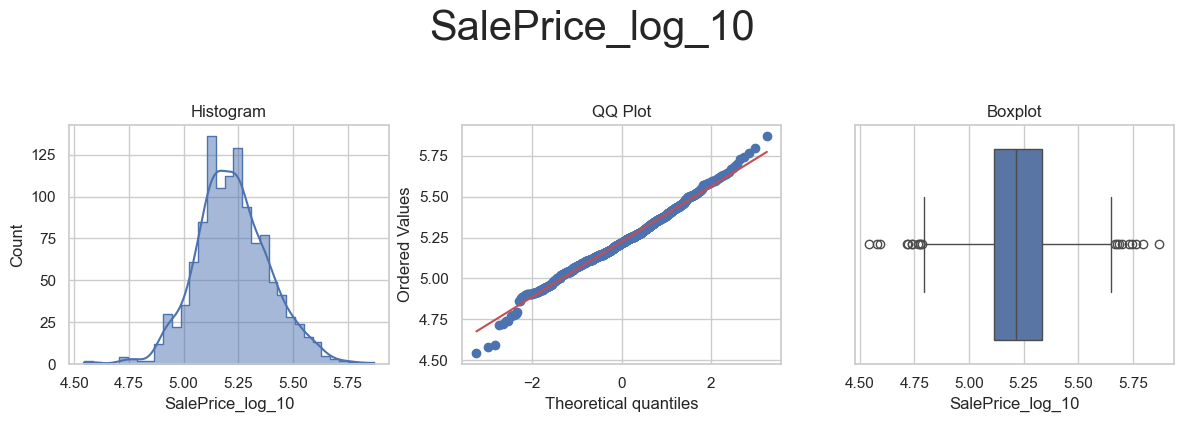

skewness: 0.12 | kurtosis: 0.7




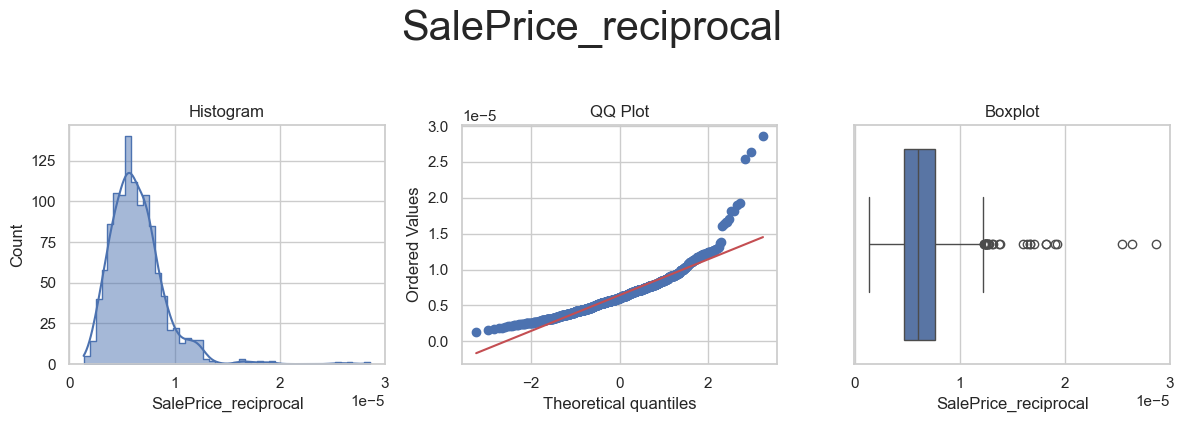

skewness: 2.02 | kurtosis: 10.34




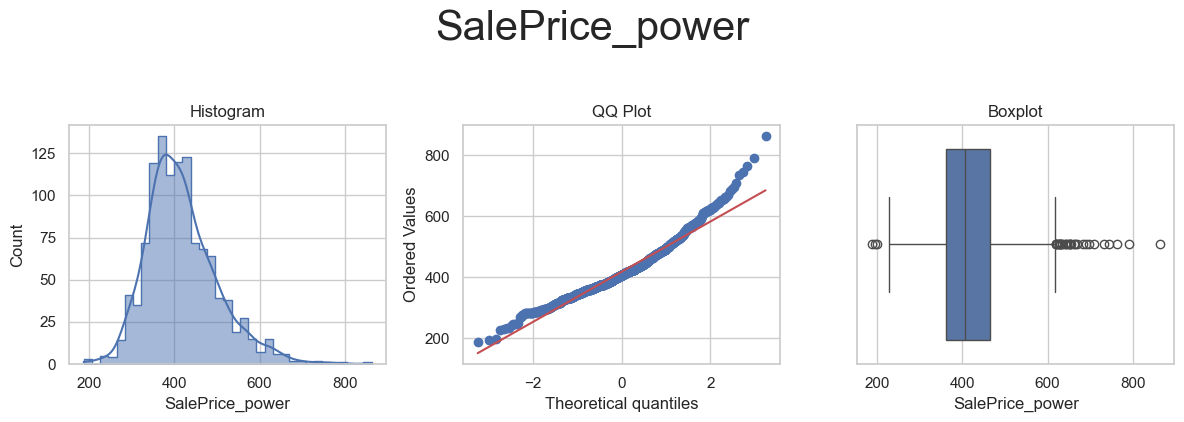

skewness: 0.89 | kurtosis: 1.66




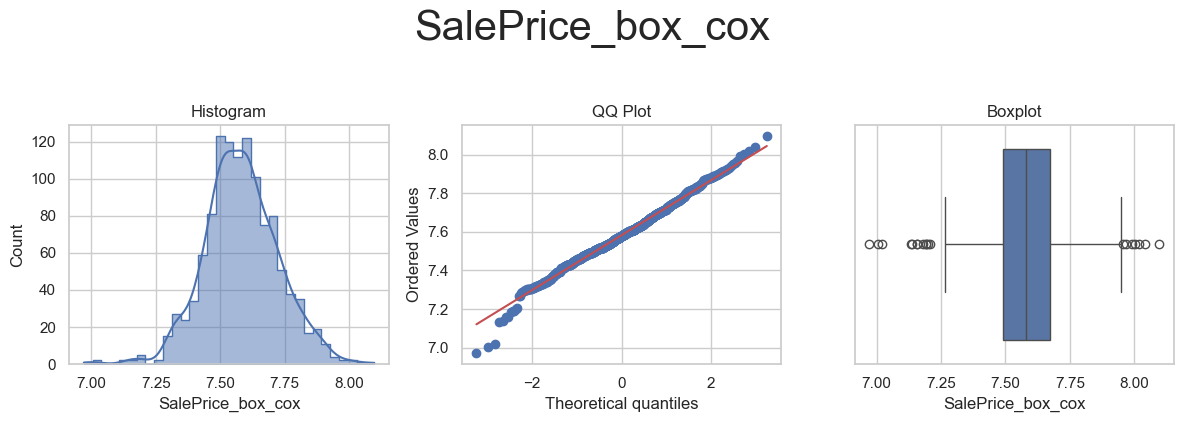

skewness: -0.01 | kurtosis: 0.78




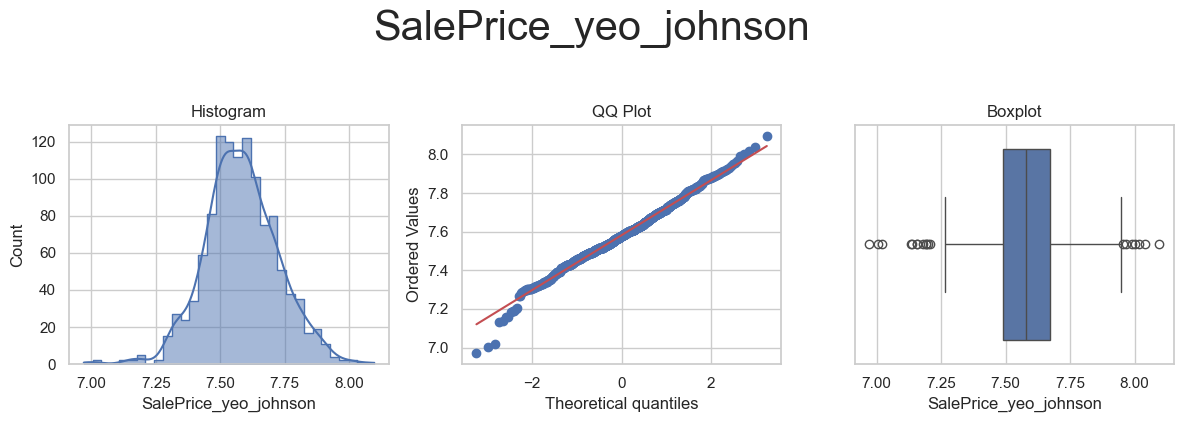

skewness: -0.01 | kurtosis: 0.78




In [24]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')


## Feature Transformation Strategy

The following table outlines the selected transformation techniques applied to numerical features in the dataset. Transformations were chosen based on distribution characteristics, the presence of skewness, and modeling considerations (e.g., improving normality, variance stabilization, or reducing outliers).

| Feature         | Transformation |
|----------------|----------------|
| 1stFlrSF        | Yeo-Johnson    |
| 2ndFlrSF        | None           |
| BedroomAbvGr    | Yeo-Johnson    |
| BsmtFinSF1      | Yeo-Johnson    |
| BsmtFinType1    | None           |
| BsmtUnfSF       | None          |
| GarageArea      | None           |
| GarageYrBlt     | None           |
| GrLivArea       | Log10          |
| LotArea         | Yeo-Johnson    |
| LotFrontage     | Yeo-Johnson    |
| MasVnrArea      | None           |
| OpenPorchSF     | None           |
| OverallCond     | None           |
| OverallQual     | None           |
| TotalBsmtSF     | Yeo-Johnson    |
| YearBuilt       | None           |
| YearRemodAdd    | None           |
| SalePrice       | Yeo-Johnson    |

### Notes:
- **Yeo-Johnson**: Applied to variables with moderate skewness, supporting zero and negative values.
- **Log10**: Applied to `GrLivArea` to reduce right-skew and compress high values.
- **Power transformation**: Custom or domain-driven transformation used for `BsmtUnfSF`.
- **None**: No transformation applied due to already appropriate distributions or ordinal/natural structure.
